# GB1 analysis 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import evoVAE.utils.seq_tools as st
import numpy as np
import logomaker as lm
import evoVAE.utils.statistics as stats
from matplotlib.patches import Patch
from scipy.stats import wasserstein_distance

%matplotlib inline

In [65]:
def plot_entropy(ancestors, extants, anc_count, ext_count, mutations, protein, title, ax, start=0, end=None, max_entropy=3):
    
    e_col_entropy = stats.calc_shannon_entropy(extants) 
    a_col_entropy = stats.calc_shannon_entropy(ancestors)

    if end is not None: 
        # across entire sequnece 
        xticks = range(start, end)
        e_col_entropy = e_col_entropy[start:end]
        a_col_entropy = a_col_entropy[start:end]
  
    else: 
        xticks = range(start, len(a_col_entropy))
   
    fig = plt.figure(figsize=(12, 8))
    ax.plot(xticks, a_col_entropy, alpha=1,  color='orange')
    ax.plot(xticks, e_col_entropy, alpha=1, color='blue')
    ax.set_xlabel("Sequence position")
    ax.set_ylabel("Entropy")
    ax.set_ylim(0, max_entropy)


    legend_elements = [
        Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
        Patch(facecolor='orange', edgecolor='black',label=f"{protein} ancestors ({anc_count} seqs)"),
        Patch(facecolor='blue', edgecolor='black', label=f"{protein} extants ({ext_count} seqs)"),
    ]

    ax.legend(handles=legend_elements,)
    # if end is not None:
    #     ax.set_xticks(xticks, labels=xticks)

    for mutation in mutations:
        ax.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

    ax.set_title(f"{protein}: {title}")
    #plt.show()

def calc_column_wasserstein_distances(ancestors, extants, ancestors_extants, variants):
    """
    Returns:
    wd_a_to_e, wd_a_to_ae, wd_e_to_ae, wd_a_to_v, wd_e_to_v, wd_ae_to_v
    """
    
    if ancestors.split(".")[-1] in ["fasta", "aln"]:
        a = st.read_aln_file(ancestors)
    else: 
        a = pd.read_pickle(ancestors)
    
    
    if ancestors_extants.split(".")[-1] in ["fasta", "aln"]:
        ae = st.read_aln_file(ancestors_extants)
    else: 
        ae = pd.read_pickle(ancestors_extants)
    
        
    if extants.split(".")[-1] in ["fasta", "aln"]:
        e = st.read_aln_file(extants)
    else: 
        e = pd.read_pickle(extants)    

    var = pd.read_csv(variants)
    var = var.rename(columns={"mutated_sequence": "sequence", "mutant": "id"})

    a_ppm = stats.calc_position_prob_matrix(a)
    e_ppm = stats.calc_position_prob_matrix(e)
    ae_ppm = stats.calc_position_prob_matrix(ae)
    var_ppm = stats.calc_position_prob_matrix(var)

    wd_a_to_e = []
    wd_a_to_ae = []
    wd_e_to_ae = []
    wd_a_to_v = []
    wd_e_to_v = []
    wd_ae_to_v = []

    for i in range(a_ppm.shape[1]):
        col_a_i = a_ppm[:, i]
        col_e_i = e_ppm[:, i]
        col_ae_i = ae_ppm[:, i]
        col_v_i = var_ppm[:, i]
        
        wd_a_to_e.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)),col_a_i, col_e_i))
        wd_a_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_a_i, col_ae_i))
        wd_e_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_ae_i))

        wd_a_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)), col_a_i, col_v_i))
        wd_e_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_v_i)) 
        wd_ae_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_ae_i, col_v_i))

    return wd_a_to_e, wd_a_to_ae, wd_e_to_ae, wd_a_to_v, wd_e_to_v, wd_ae_to_v
    
    
    

In [ ]:
meta = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_substitutions.csv")
#print(meta.columns)
meta[meta["DMS_id"] == "SPG1_STRSG_Wu_2016"]["target_seq"].values[0]

The following residues were modified

They all lie within 15 residues of each other 

The distribution of data is very skewed though
"While most mutants had a lower fitness compared to WT (fitness < 1), 2.4% of mutants were beneficial (fitness > 1)."

### GB1 - variant distribution 

In [6]:
gb1_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/SPG1_STRSG_Wu_2016.csv")
gb1_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,D266A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,2.401243,1
1,D266A:G267A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.259549,1
2,D266A:G267A:V280A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,6.201135,1
3,D266A:G267A:V280C,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,2.705083,1
4,D266A:G267A:V280E,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.004726,0


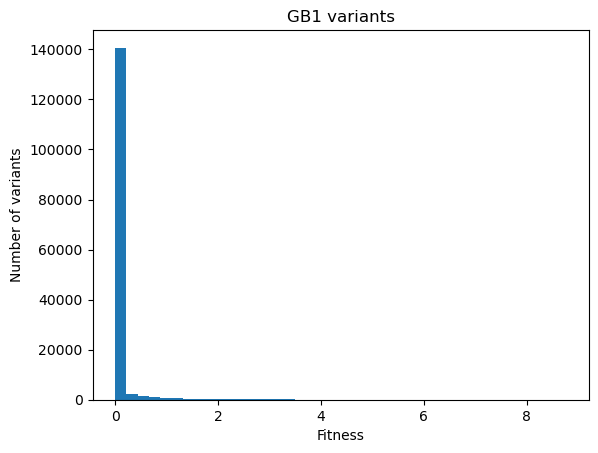

In [6]:
gb1_variants["DMS_score"].describe()

plt.hist(gb1_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("GB1 variants")
plt.show()

### GB1 - entropy 

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 455
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 8343
Sequence weight numpy array created with shape (num_seqs, columns):  (2286, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (12733, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (455, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (8343, 448)


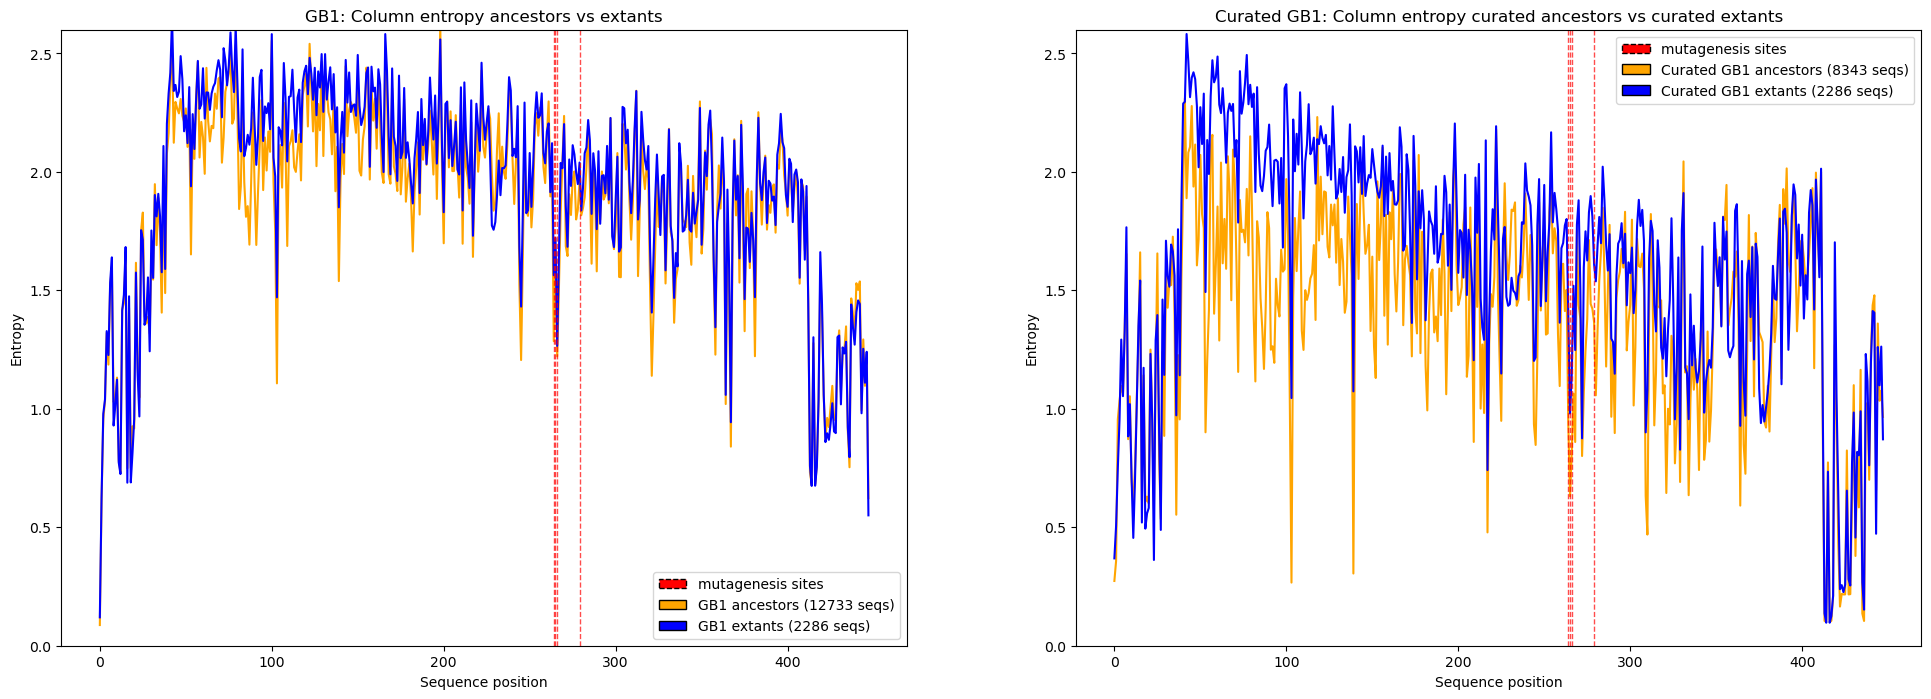

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

Sequence weight numpy array created with shape (num_seqs, columns):  (2286, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (12733, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (455, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (8343, 448)


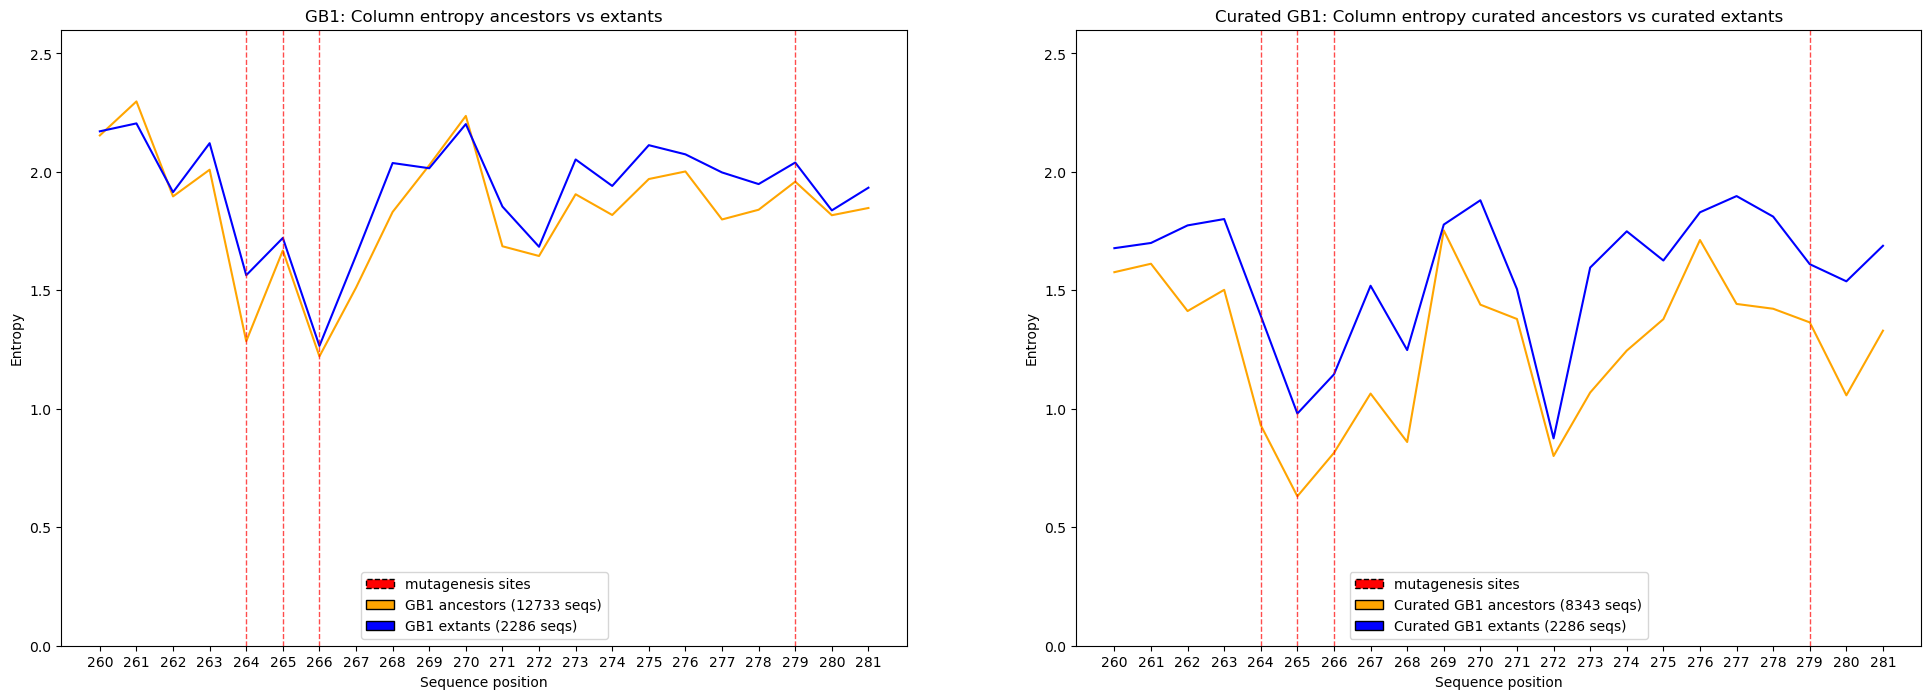

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [145]:
################ UNCURATED ##############

aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/"
gb1_e = pd.read_pickle(aln_path + "gb1_extants_no_dupes.pkl")
gb1_a = pd.read_pickle(aln_path + "gb1_ancestors_no_dupes.pkl")



################### CURATED ANCESTORS & EXTANTS ##################
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/"
curated_gb1_e = st.read_aln_file(aln_path + "gb1_0.32_sim_extants_no_dupes.aln")
curated_gb1_a = st.read_aln_file(aln_path + "gb1_0.32_sim_ancestors_no_dupes.aln")



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

plot_entropy(ancestors=gb1_a, extants=gb1_e, anc_count=12733, 
             ext_count=2286, mutations = [264, 265, 266, 279], protein="GB1", 
             title="Column entropy ancestors vs extants", ax=ax1)

plot_entropy(ancestors=curated_gb1_a, extants=curated_gb1_e, anc_count=8343, 
             ext_count=2286, mutations = [264, 265, 266, 279], protein="Curated GB1", 
             title="Column entropy curated ancestors vs curated extants", ax=ax2)

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# do across a smaller range 
plot_entropy(ancestors=gb1_a, extants=gb1_e, anc_count=12733, 
             ext_count=2286, mutations = [264, 265, 266, 279], protein="GB1", 
             title="Column entropy ancestors vs extants", start=260, end=282, ax=ax1)


plot_entropy(ancestors=curated_gb1_a, extants=curated_gb1_e, anc_count=8343, 
             ext_count=2286, mutations = [264, 265, 266, 279], protein="Curated GB1", 
             title="Column entropy curated ancestors vs curated extants", start=260, end=282, ax=ax2)

plt.show()

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 455
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 8343
Index(['id', 'sequence', 'DMS_score', 'DMS_score_bin'], dtype='object')
Sequence weight numpy array created with shape (num_seqs, columns):  (149360, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (455, 448)


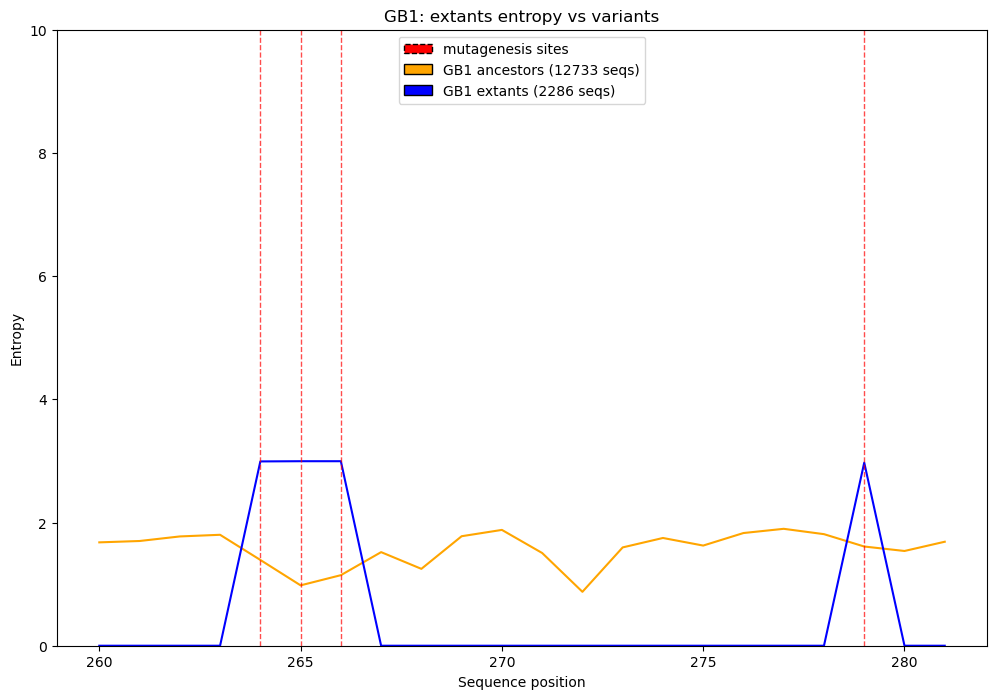

<Figure size 1200x800 with 0 Axes>

Sequence weight numpy array created with shape (num_seqs, columns):  (149360, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (8343, 448)


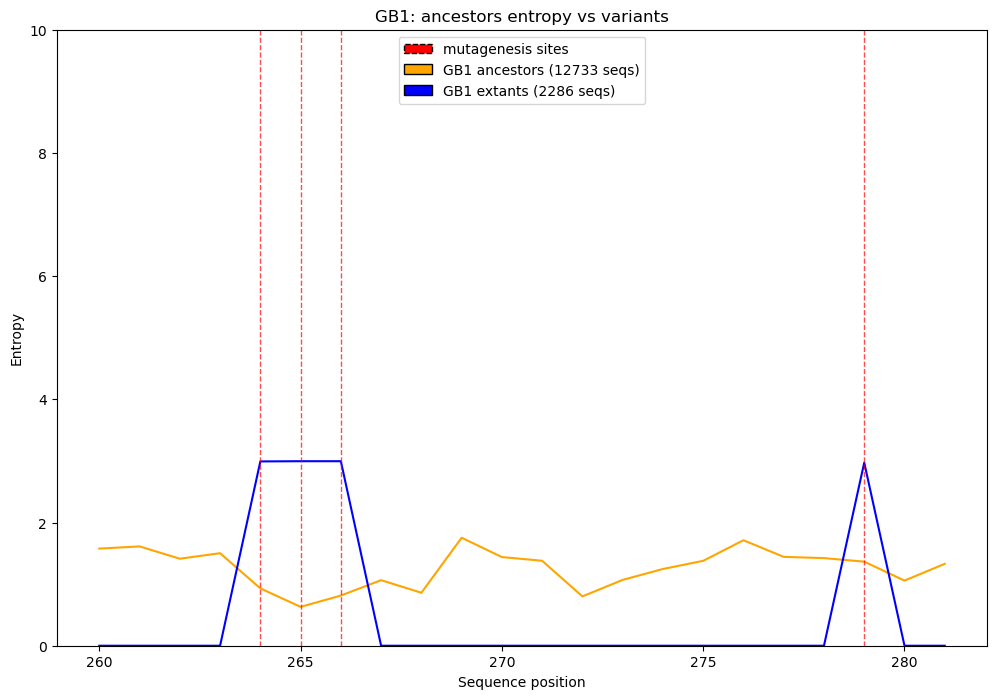

<Figure size 1200x800 with 0 Axes>

Sequence weight numpy array created with shape (num_seqs, columns):  (12733, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (8343, 448)


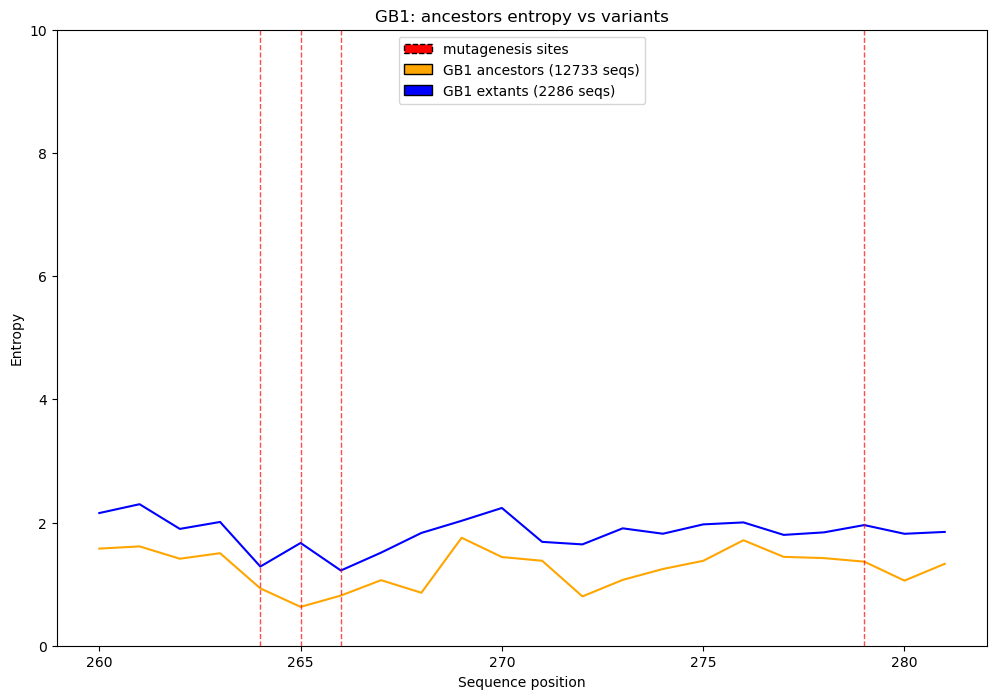

<Figure size 1200x800 with 0 Axes>

In [57]:

aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/"
curated_gb1_e = st.read_aln_file(aln_path + "gb1_0.32_sim_extants_no_dupes.aln")
curated_gb1_a = st.read_aln_file(aln_path + "gb1_0.32_sim_ancestors_no_dupes.aln")

var = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/SPG1_STRSG_Wu_2016.csv")
var.rename(columns={"mutant": "id", "mutated_sequence": "sequence"}, inplace=True)
print(var.columns)

fig, ax1 = plt.subplots(1,1, figsize=(12,8))
plot_entropy(ancestors=curated_gb1_e, extants=var, anc_count=12733, 
             ext_count=2286, mutations = [264, 265, 266, 279], protein="GB1", 
             title="extants entropy vs variants", start=260, end=282, ax=ax1)

plt.show()

fig, ax1 = plt.subplots(1,1, figsize=(12,8))
plot_entropy(ancestors=curated_gb1_a, extants=var, anc_count=12733, 
             ext_count=2286, mutations = [264, 265, 266, 279], protein="GB1", 
             title="ancestors entropy vs variants", start=260, end=282, ax=ax1)

plt.show()



aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/"
gb1_a = pd.read_pickle(aln_path + "gb1_ancestors_no_dupes.pkl")

fig, ax1 = plt.subplots(1,1, figsize=(12,8))
plot_entropy(ancestors=curated_gb1_a, extants=gb1_a, anc_count=12733, 
             ext_count=2286, mutations = [264, 265, 266, 279], protein="GB1", 
             title="ancestors entropy vs variants", start=260, end=282, ax=ax1)

plt.show()

#### GB1 - Wasserstein distance 

Sequence weight numpy array created with shape (num_seqs, columns):  (12733, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (2286, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (14276, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (149360, 448)
Dist A-E: 0.5723476482787782
Dist A-AE: 0.06189802838018126
Dist E-AE: 0.5154249919472801
Dist A-V: 5.289377921863789
Dist E-V: 5.457538960734717
Dist AE-V: 5.309562562929609
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 8343
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_ancestors_0.32_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 8655
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profi

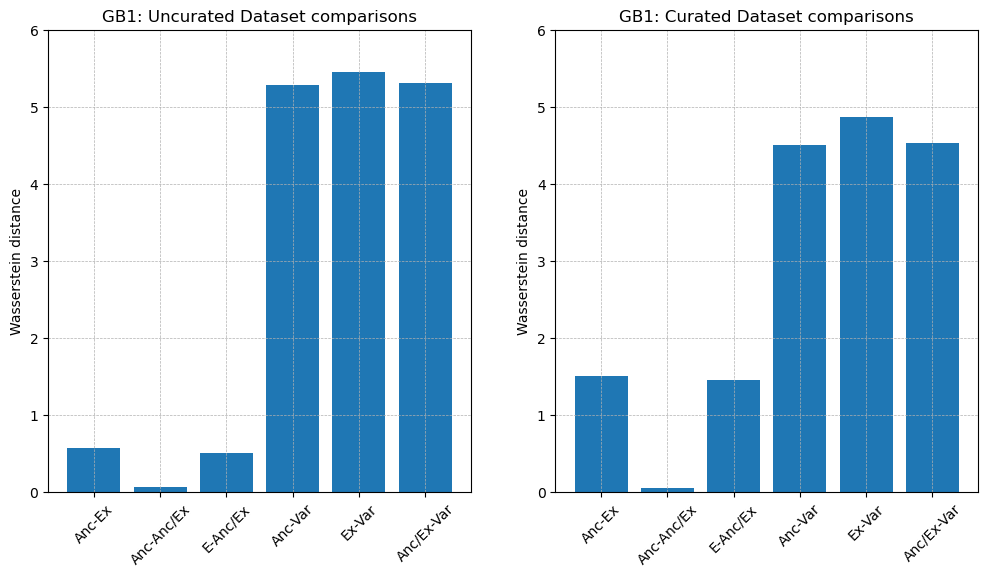

In [43]:


################ UNCURATED ##############
path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/"
wd_a_to_e, wd_a_to_ae, wd_e_to_ae, wd_a_to_v, wd_e_to_v, wd_ae_to_v = calc_column_wasserstein_distances(
    ancestors= path + "gb1_ancestors_no_dupes.pkl",
    extants= path + "gb1_extants_no_dupes.pkl",
    ancestors_extants= path + "gb1_ancestors_extants_no_dupes.pkl",
    variants="/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/SPG1_STRSG_Wu_2016.csv")

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")

################### CURATED ANCESTORS & EXTANTS ##################

path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/"
wd_curated_a_to_curated_e, wd_curated_a_to_curated_ae, wd_curated_e_to_curated_ae, wd_curated_a_to_v, wd_curated_e_to_v, wd_curated_ae_to_v = calc_column_wasserstein_distances(
    ancestors= path + "gb1_0.32_sim_ancestors_no_dupes.aln",
    extants= path + "gb1_0.32_sim_extants_no_dupes.aln",
    ancestors_extants= path + "gb1_0.32_sim_ancestors_0.32_sim_extants_no_dupes.aln",
    variants="/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/SPG1_STRSG_Wu_2016.csv")

print(f"Dist curated A-E: {np.mean(wd_curated_a_to_curated_e)}")
print(f"Dist curated A-AE: {np.mean(wd_curated_a_to_curated_ae)}")
print(f"Dist curated E-AE: {np.mean(wd_curated_e_to_curated_ae)}") 

print(f"Dist curated A-V: {np.mean(wd_curated_a_to_v)}")
print(f"Dist curated E-V: {np.mean(wd_curated_e_to_v)}")
print(f"Dist curated AE-V: {np.mean(wd_curated_ae_to_v)}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_e_to_v), np.mean(wd_ae_to_v)])
ax1.set_title("GB1: Uncurated Dataset comparisons")
ax1.set_ylabel("Wasserstein distance")
ax1.set_xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], rotation=45)
ax1.set_ylim(0,6)
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)


ax2.bar(np.arange(6), [np.mean(wd_curated_a_to_curated_e), np.mean(wd_curated_a_to_curated_ae), np.mean(wd_curated_e_to_curated_ae), np.mean(wd_curated_a_to_v), np.mean(wd_curated_e_to_v), np.mean(wd_curated_ae_to_v)])
ax2.set_title("GB1: Curated Dataset comparisons")
ax2.set_ylabel("Wasserstein distance")
ax2.set_xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], rotation=45)
ax2.set_ylim(0,6)
ax2.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)


plt.show()


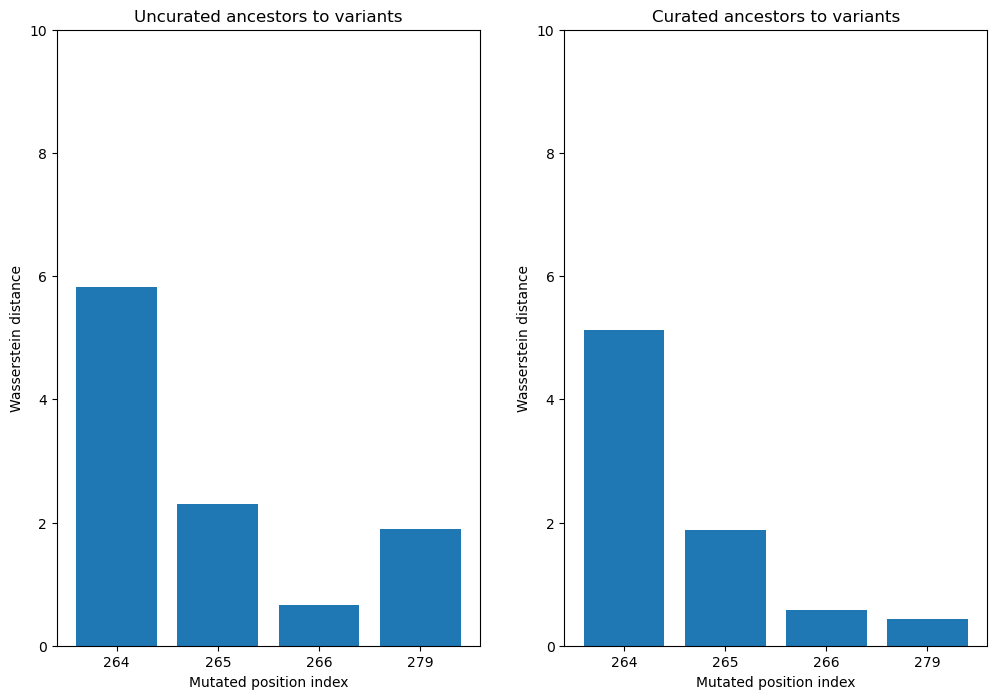

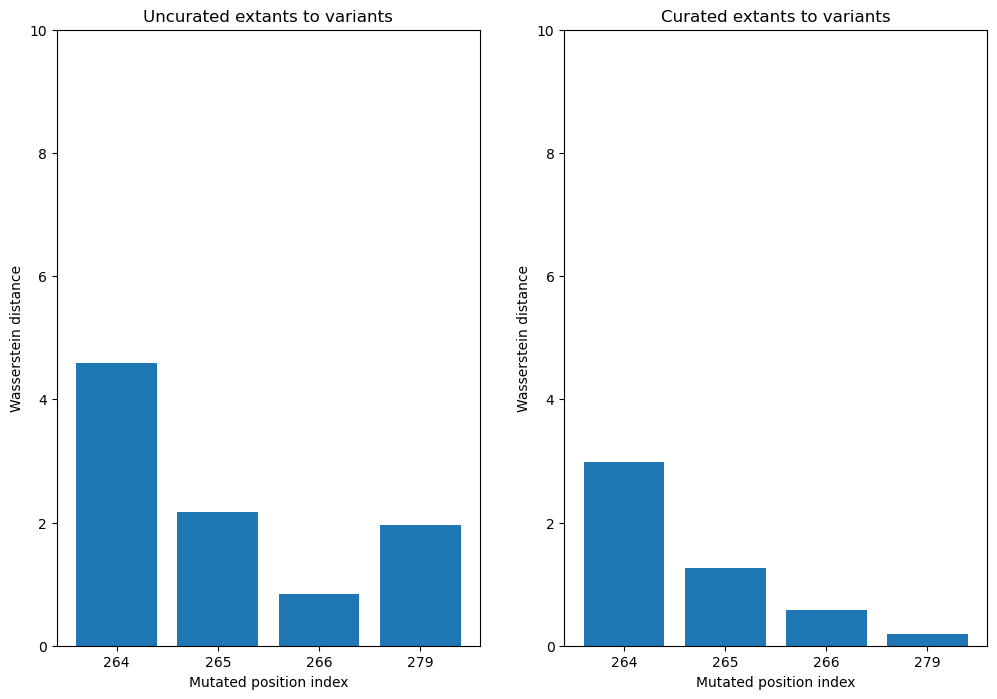

In [81]:
#wd_a_to_v, wd_curated_e_to_v, wd_ae_to_v


def plot_wasserstein_dist(data, mutations, title, ax, ylim=10):
    scores = [x for idx,x in enumerate(data) if idx in mutations]
    ax.bar(np.arange(len(mutations)), scores)
    ax.set_xticks(ticks=np.arange(len(mutations)), labels=mutations)
    ax.set_title(title)
    ax.set_ylim(0,ylim)
    ax.set_xlabel("Mutated position index")
    ax.set_ylabel("Wasserstein distance")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
mutations = [264, 265, 266, 279]
plot_wasserstein_dist(wd_a_to_v, mutations=mutations, title="Uncurated ancestors to variants", ax=ax1)


mutations = [264, 265, 266, 279]
plot_wasserstein_dist(wd_curated_a_to_v, mutations=mutations, title="Curated ancestors to variants", ax=ax2)

plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
mutations = [264, 265, 266, 279]
plot_wasserstein_dist(wd_e_to_v, mutations=mutations, title="Uncurated extants to variants", ax=ax1)


mutations = [264, 265, 266, 279]
plot_wasserstein_dist(wd_curated_e_to_v, mutations=mutations, title="Curated extants to variants", ax=ax2)

plt.show()

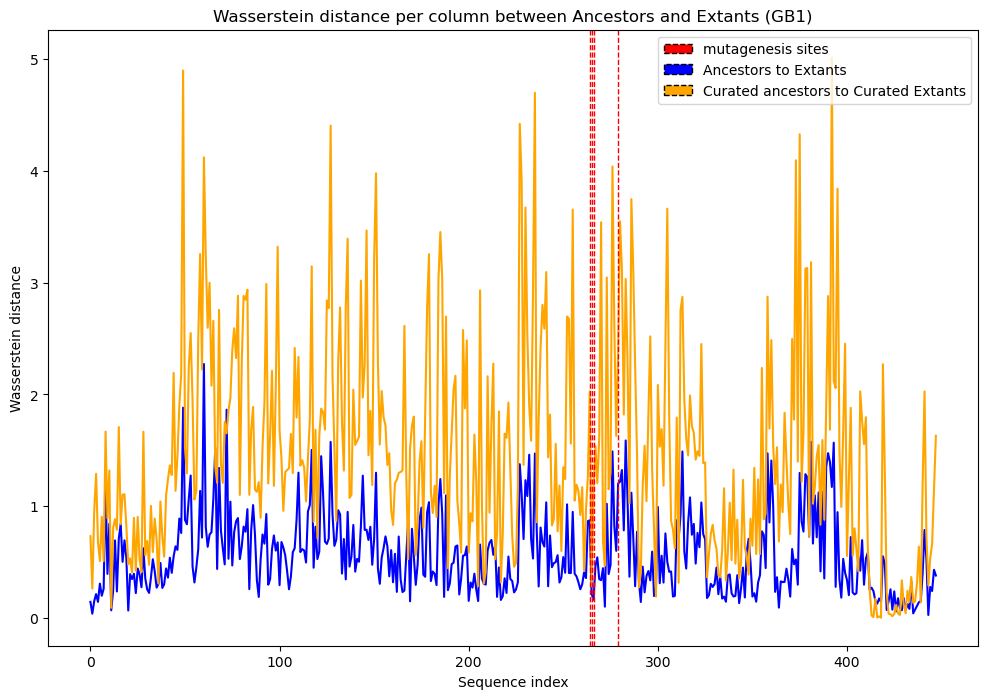

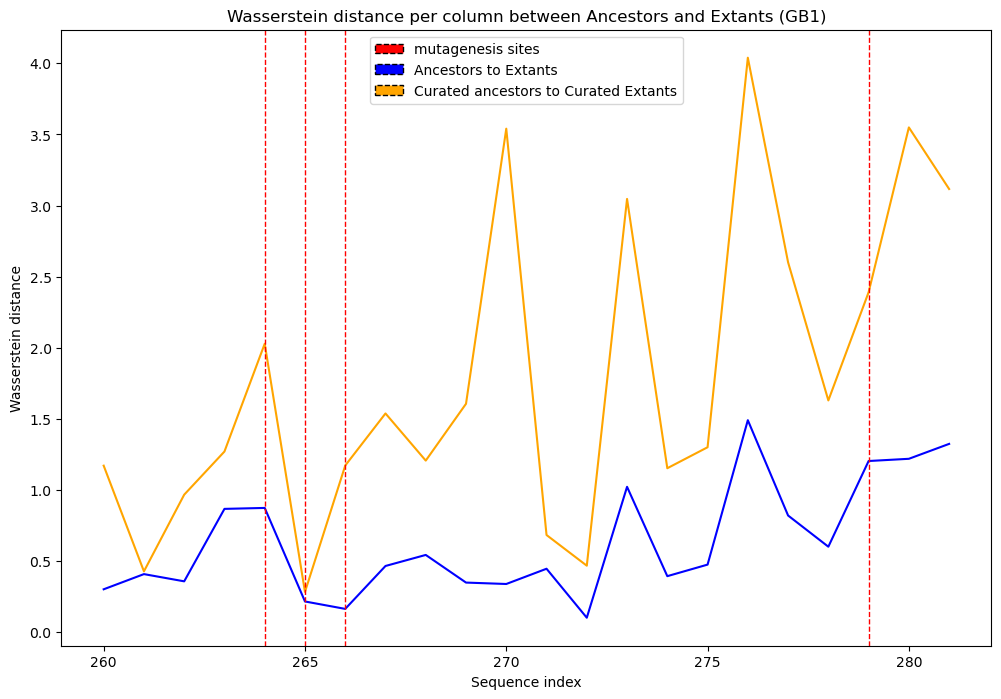

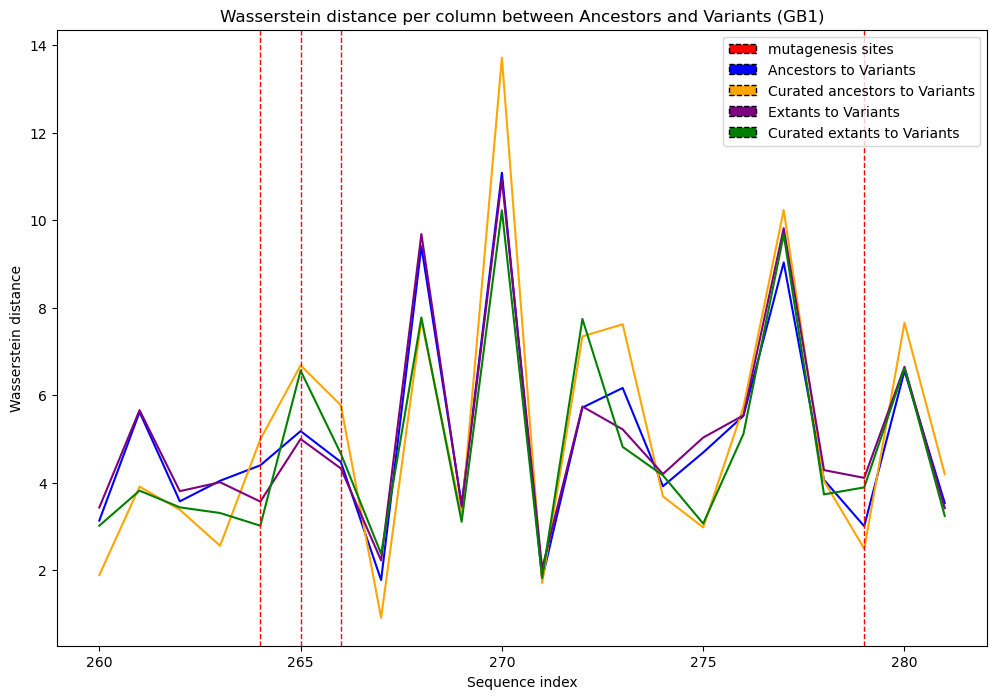

In [62]:
################  ##############
xticks = range(0, len(wd_a_to_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, wd_a_to_e, alpha=1, color='blue', label="Ancestors-Extants")
plt.plot(xticks, wd_curated_a_to_curated_e, alpha=1, color='orange', label="Curated Ancestors- Curated Extants")
mutations = [264, 265, 266, 279]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=1)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',linestyle='--', label='Ancestors to Extants '),
    Patch(facecolor='orange', edgecolor='black',linestyle='--', label='Curated ancestors to Curated Extants'),
]

plt.legend(handles=legend_elements,)
plt.ylabel("Wasserstein distance")
plt.xlabel("Sequence index")
plt.title("Wasserstein distance per column between Ancestors and Extants (GB1)")
plt.show()


################### ONLY ACROSS MUTATIONS ##################
xticks = range(0, len(wd_curated_a_to_curated_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks[260:282], wd_a_to_e[260:282], alpha=1, color='blue', label="Ancestors-Extants")
plt.plot(xticks[260:282], wd_curated_a_to_curated_e[260:282], alpha=1, color='orange', label="Curated ancestors-Extants")


mutations = [264, 265, 266, 279]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=1)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',linestyle='--', label='Ancestors to Extants '),
    Patch(facecolor='orange', edgecolor='black',linestyle='--', label='Curated ancestors to Curated Extants'),
]

plt.legend(handles=legend_elements,)
plt.ylabel("Wasserstein distance")
plt.xlabel("Sequence index")

plt.title("Wasserstein distance per column between Ancestors and Extants (GB1)")
plt.show()

################### ONLY ACROSS MUTATIONS ##################
xticks = range(0, len(wd_curated_a_to_curated_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks[260:282], wd_a_to_v[260:282], alpha=1, color='blue')
plt.plot(xticks[260:282], wd_curated_a_to_v[260:282], alpha=1, color='orange')

plt.plot(xticks[260:282], wd_e_to_v[260:282], alpha=1, color='purple')
plt.plot(xticks[260:282], wd_curated_e_to_v[260:282], alpha=1, color='green')

mutations = [264, 265, 266, 279]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=1)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',linestyle='--', label='Ancestors to Variants '),
    Patch(facecolor='orange', edgecolor='black',linestyle='--', label='Curated ancestors to Variants'),
    Patch(facecolor='purple', edgecolor='black',linestyle='--', label='Extants to Variants '),
    Patch(facecolor='green', edgecolor='black',linestyle='--', label='Curated extants to Variants'),
]

plt.legend(handles=legend_elements,)
plt.ylabel("Wasserstein distance")
plt.xlabel("Sequence index")

plt.title("Wasserstein distance per column between Ancestors and Variants (GB1)")
plt.show()

### GB1 - curated sequence weights distribtutions

In [4]:


aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/"
gb1_e = pd.read_pickle(aln_path + "gb1_extants_no_dupes.pkl")
gb1_a = pd.read_pickle(aln_path + "gb1_ancestors_no_dupes.pkl")
gb1_ae = pd.read_pickle(aln_path + "gb1_ancestors_extants_no_dupes.pkl")

aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/"
curated_gb1_e = st.read_aln_file(aln_path + "gb1_0.32_sim_extants_no_dupes.aln")
curated_gb1_a = st.read_aln_file(aln_path + "gb1_0.32_sim_ancestors_no_dupes.aln")
curated_gb1_ae = st.read_aln_file(aln_path + "gb1_0.32_sim_ancestors_0.32_sim_extants_no_dupes.aln")

datasets = [gb1_e, gb1_a, gb1_ae, curated_gb1_e, curated_gb1_a, curated_gb1_ae]

for data in datasets:
    numpy_aln, _, _ = st.convert_msa_numpy_array(data)
    data["seq_sim"] = st.reweight_by_seq_similarity(numpy_aln, 0.2)
    data["col_sim"] = st.position_based_seq_weighting(numpy_aln, 4)


Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 455
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 8343
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_ancestors_0.32_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 8655
Sequence weight numpy array created with shape (num_seqs, columns):  (2286, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (12733, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (14276, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (455, 448)
Sequence weight numpy array created with shape (num_

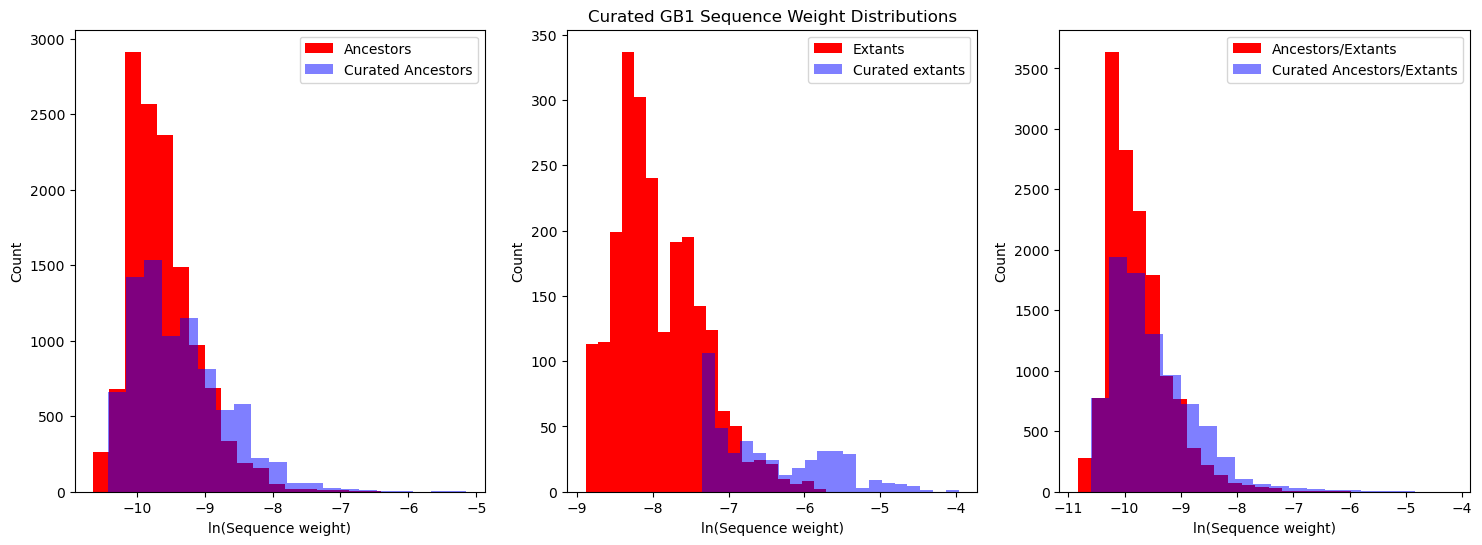

In [38]:


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.hist(np.log(gb1_a["col_sim"]), color="red", alpha=1, bins=20, label="Ancestors")
ax1.hist(np.log(curated_gb1_a["col_sim"]), color="blue", alpha=0.5, bins=20, label="Curated Ancestors")

ax1.set_ylabel("Count")
ax1.set_xlabel("ln(Sequence weight)")

ax1.legend()


ax2.hist(np.log(gb1_e["col_sim"]), color="red", alpha=1, bins=20, label="Extants")
ax2.hist(np.log(curated_gb1_e["col_sim"]), color="blue", alpha=0.5, bins=20, label="Curated extants")

ax2.set_ylabel("Count")
ax2.set_xlabel("ln(Sequence weight)")

ax2.set_title("Curated GB1 Sequence Weight Distributions")
ax2.legend()



ax3.hist(np.log(gb1_ae["col_sim"]), color="red", alpha=1, bins=20, label="Ancestors/Extants")
ax3.hist(np.log(curated_gb1_ae["col_sim"]), color="blue", alpha=0.5, bins=20, label="Curated Ancestors/Extants")
ax3.set_ylabel("Count")
ax3.set_xlabel("ln(Sequence weight)")

ax3.legend()

plt.show()



# GFP 

In [5]:
gfp_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GFP_AEQVI_Sarkisyan_2016.csv")
gfp_variants.shape

(51714, 4)

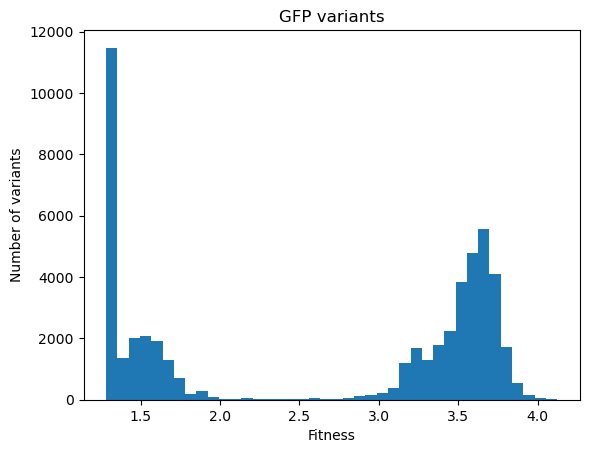

In [63]:
plt.hist(gfp_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("GFP variants")
plt.show()

Sequence weight numpy array created with shape (num_seqs, columns):  (324, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (497, 238)


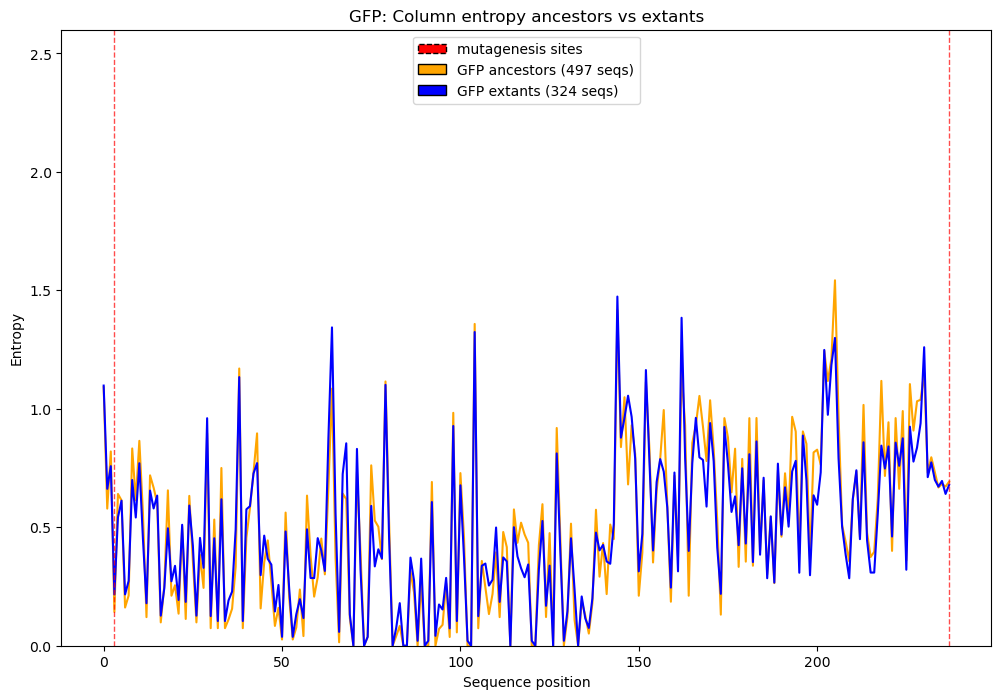

<Figure size 1200x800 with 0 Axes>

In [8]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gfp/independent_runs/no_synthetic/alns/"
gfp_e = pd.read_pickle(aln_path + "gfp_extants_no_syn_no_dupes.pkl")
gfp_a = pd.read_pickle(aln_path + "gfp_ancestors_no_syn_no_dupes.pkl")

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

plot_entropy(ancestors=gfp_a, extants=gfp_e, anc_count=497, 
             ext_count=324, mutations = [3, 237], protein="GFP", 
             title="Column entropy ancestors vs extants", ax=ax1)


plt.show()


##### GFP - Wasserstein distance 

Sequence weight numpy array created with shape (num_seqs, columns):  (497, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (324, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (673, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (51714, 238)
Dist A-E: 0.2759415972961954
Dist A-AE: 0.06325623399643425
Dist E-AE: 0.22453658421158343
Dist A-V: 0.9283286071308591
Dist E-V: 0.8032552909782081
Dist AE-V: 0.9213718999208078


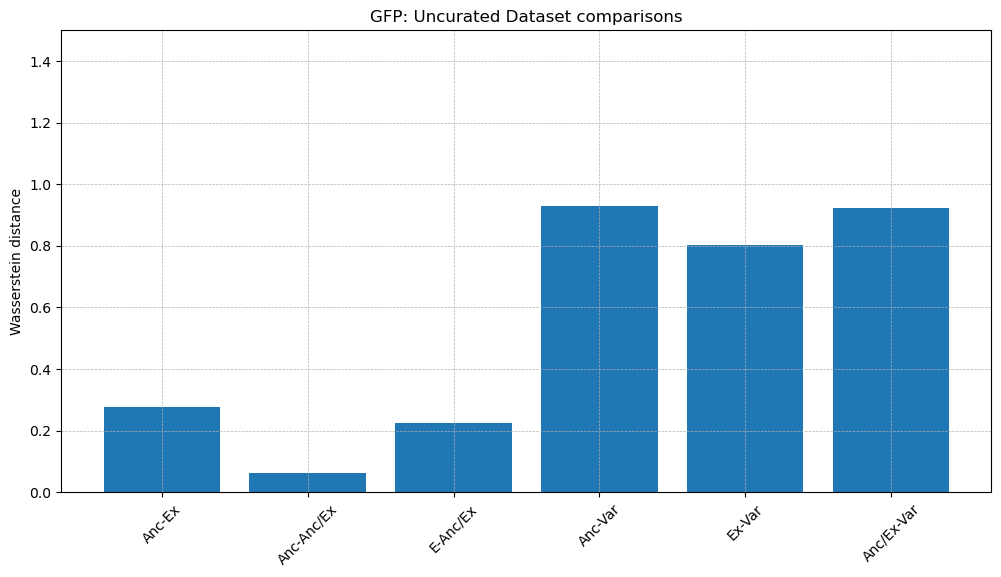

In [37]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/gfp/independent_runs/no_synthetic/alns/"
wd_a_to_e, wd_a_to_ae, wd_e_to_ae, wd_a_to_v, wd_e_to_v, wd_ae_to_v = calc_column_wasserstein_distances(
    ancestors= path + "gfp_ancestors_no_syn_no_dupes.pkl",
    extants= path + "gfp_extants_no_syn_no_dupes.pkl",
    ancestors_extants= path + "gfp_ancestors_extants_no_syn_no_dupes.pkl",
    variants="/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GFP_AEQVI_Sarkisyan_2016.csv")

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 6))

ax1.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_e_to_v), np.mean(wd_ae_to_v)])
ax1.set_title("GFP: Uncurated Dataset comparisons")
ax1.set_ylabel("Wasserstein distance")
ax1.set_xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], rotation=45)
ax1.set_ylim(0,1.5)
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.show()


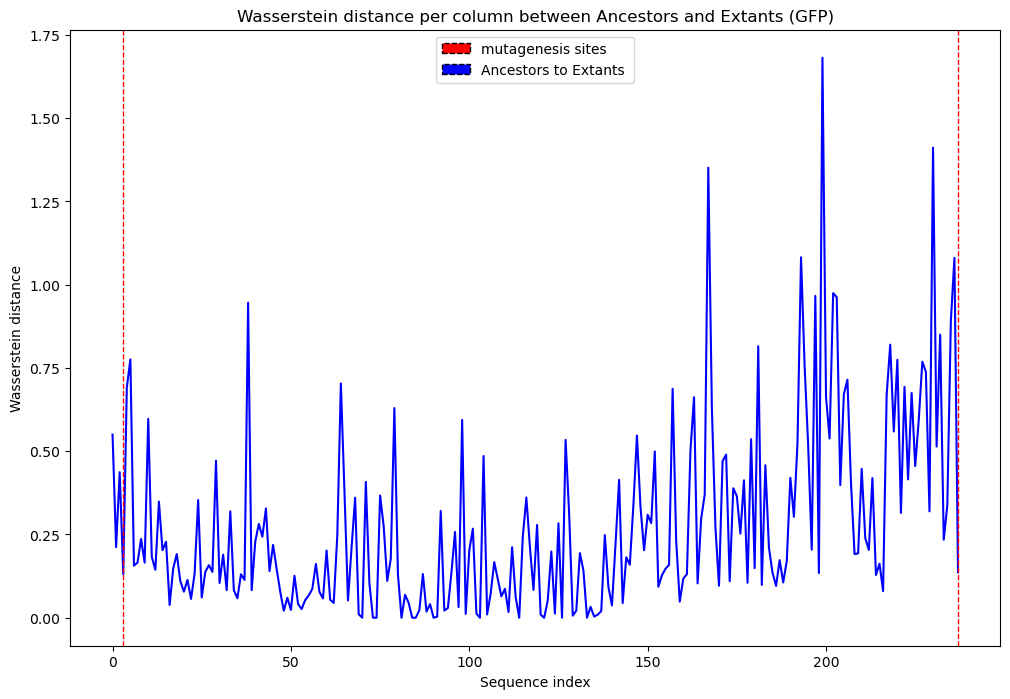

In [11]:

################ UNCURATED ##############
xticks = range(0, len(wd_a_to_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, wd_a_to_e, alpha=1, color='blue', label="Ancestors-Extants")
mutations = [3, 237]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=1)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',linestyle='--', label='Ancestors to Extants '),
]

plt.legend(handles=legend_elements,)
plt.ylabel("Wasserstein distance")
plt.xlabel("Sequence index")
plt.title("Wasserstein distance per column between Ancestors and Extants (GFP)")
plt.show()

# A4 

In [76]:
#672-713 (673) /Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns A4_HUMAN_Seuma_2022

a4_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/A4_HUMAN_Seuma_2022.csv")
a4_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,A673C,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-1.018869,1
1,A673D,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-0.605052,1
2,A673E,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-0.590857,1
3,A673E:A692E,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-2.443601,0
4,A673E:A692T,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-3.049893,0


In [99]:
# all the mutation positoins will be here 
a4_muts = set()

for x in a4_variants["mutant"]:
    data = x.split(":")
    a = data[0][1:-1]
    a4_muts.add(a)
    if len(data) == 2:
        b = data[1][1:-1]
        a4_muts.add(b)
len(a4_muts)
print(min(a4_muts), max(a4_muts))

672 713


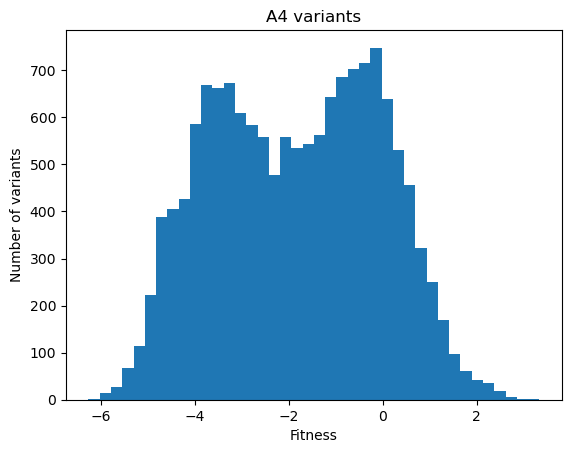

In [78]:
a4_variants["DMS_score"].describe()

plt.hist(a4_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("A4 variants")
plt.show()

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/a4_human/curated/alns/a4_0.6_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 1978
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/a4_human/curated/alns/a4_0.6_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 9755
Sequence weight numpy array created with shape (num_seqs, columns):  (4936, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (29940, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (1978, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (9755, 770)


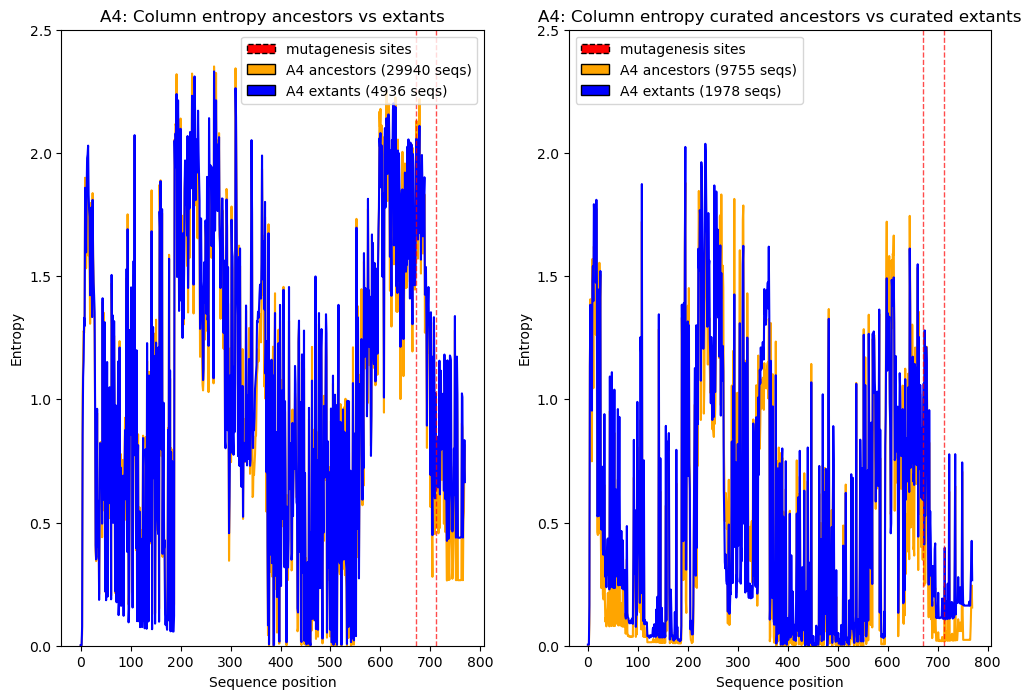

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

Sequence weight numpy array created with shape (num_seqs, columns):  (4936, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (29940, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (1978, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (9755, 770)


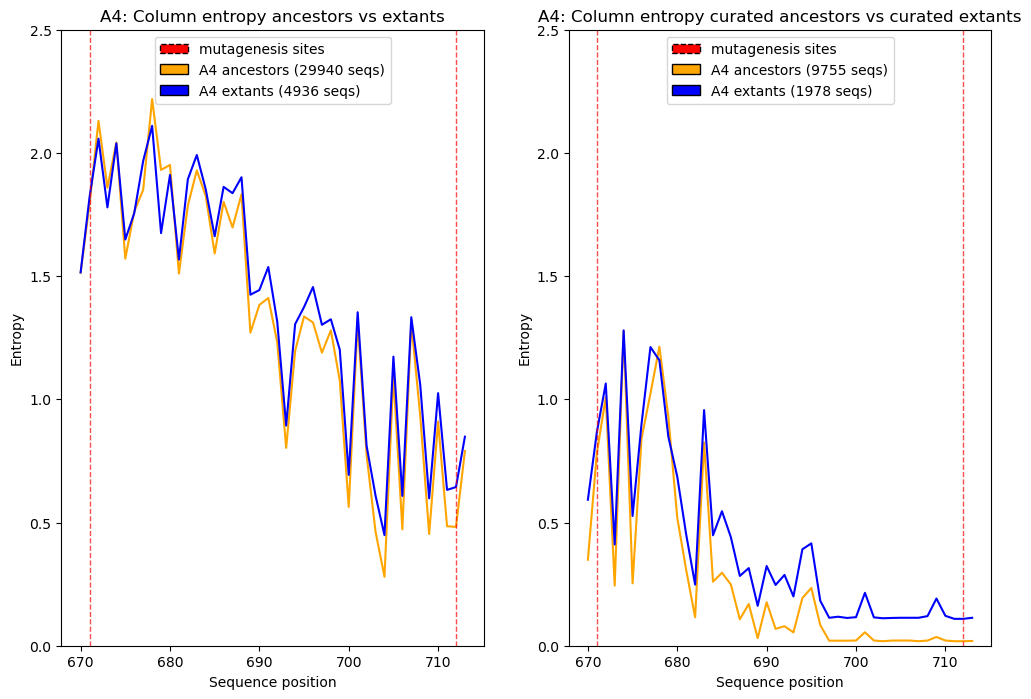

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [70]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/"
a4_e = pd.read_pickle(aln_path + "a4_extants_no_dupes.pkl")
a4_a = pd.read_pickle(aln_path + "a4_ancestors_no_dupes.pkl")


################### CURATED ANCESTORS & EXTANTS ##################
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/curated/alns/"
curated_a4_e = st.read_aln_file(aln_path + "a4_0.6_sim_extants_no_dupes.aln")
curated_a4_a = st.read_aln_file(aln_path + "a4_0.6_sim_ancestors_no_dupes.aln")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

plot_entropy(ancestors=a4_a, extants=a4_e, anc_count=29940 , 
             ext_count=4936, mutations = [671, 712], protein="A4", 
             title="Column entropy ancestors vs extants", ax=ax1, max_entropy=2.5)


plot_entropy(ancestors=curated_a4_a, extants=curated_a4_e, anc_count=9755 , 
             ext_count=1978, mutations = [671, 712], protein="A4", 
             title="Column entropy curated ancestors vs curated extants", ax=ax2, max_entropy=2.5)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

plot_entropy(ancestors=a4_a, extants=a4_e, anc_count=29940 , 
             ext_count=4936, mutations = [671, 712], protein="A4", 
             title="Column entropy ancestors vs extants", ax=ax1, max_entropy=2.5, start=670, end=714)


plot_entropy(ancestors=curated_a4_a, extants=curated_a4_e, anc_count=9755 , 
             ext_count=1978, mutations = [671, 712], protein="A4", 
             title="Column entropy curated ancestors vs curated extants", ax=ax2, max_entropy=2.5, start=670, end=714)
plt.show()





### A4 Wasserstein distance

Sequence weight numpy array created with shape (num_seqs, columns):  (29940, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (4936, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (32125, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (14811, 770)
Dist A-E: 0.4878374722179349
Dist A-AE: 0.04033496798707995
Dist E-AE: 0.45588935371901274
Dist A-V: 2.542896856049938
Dist E-V: 2.525549198806503
Dist AE-V: 2.551939310784068
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/a4_human/curated/alns/a4_0.6_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 9755
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/a4_human/curated/alns/a4_0.6_sim_ancestors_0.6_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 10725
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/a4_human/curated/alns

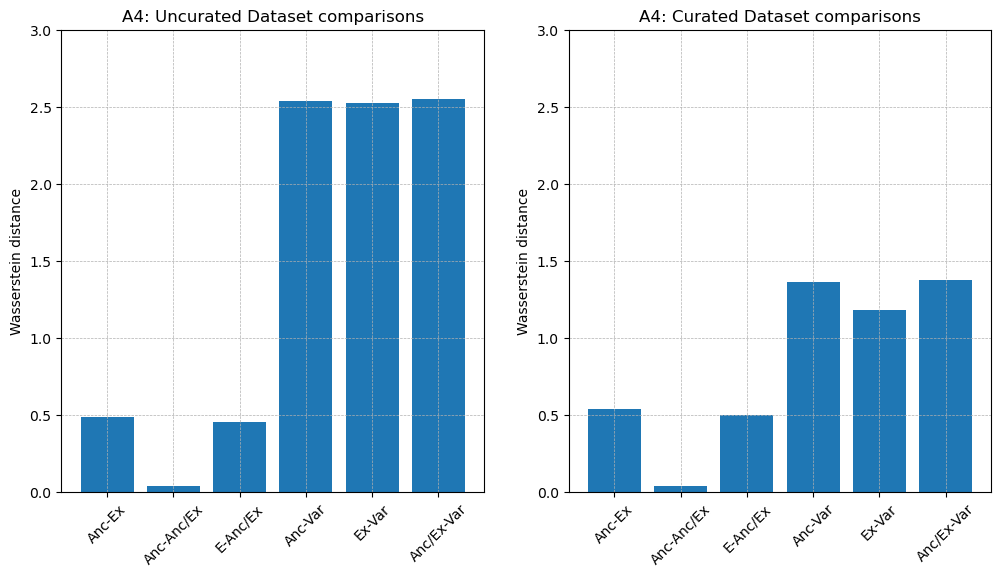

In [77]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/"

wd_a_to_e, wd_a_to_ae, wd_e_to_ae, wd_a_to_v, wd_e_to_v, wd_ae_to_v = calc_column_wasserstein_distances(
    ancestors= path + "a4_ancestors_no_dupes.pkl",
    extants= path + "a4_extants_no_dupes.pkl",
    ancestors_extants= path + "a4_ancestors_extants_no_dupes.pkl",
    variants="/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/A4_HUMAN_Seuma_2022.csv")

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")

################### CURATED ANCESTORS & EXTANTS ##################

path = "/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/curated/alns/"
wd_curated_a_to_curated_e, wd_curated_a_to_curated_ae, wd_curated_e_to_curated_ae, wd_curated_a_to_v, wd_curated_e_to_v, wd_curated_ae_to_v = calc_column_wasserstein_distances(
    ancestors= path + "a4_0.6_sim_ancestors_no_dupes.aln",
    extants= path + "a4_0.6_sim_extants_no_dupes.aln",
    ancestors_extants= path + "a4_0.6_sim_ancestors_0.6_sim_extants_no_dupes.aln",
    variants="/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/A4_HUMAN_Seuma_2022.csv")

print(f"Dist curated A-E: {np.mean(wd_curated_a_to_curated_e)}")
print(f"Dist curated A-AE: {np.mean(wd_curated_a_to_curated_ae)}")
print(f"Dist curated E-AE: {np.mean(wd_curated_e_to_curated_ae)}") 

print(f"Dist curated A-V: {np.mean(wd_curated_a_to_v)}")
print(f"Dist curated E-V: {np.mean(wd_curated_e_to_v)}")
print(f"Dist curated AE-V: {np.mean(wd_curated_ae_to_v)}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_e_to_v), np.mean(wd_ae_to_v)])
ax1.set_title("A4: Uncurated Dataset comparisons")
ax1.set_ylabel("Wasserstein distance")
ax1.set_xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], rotation=45)
ax1.set_ylim(0,3)
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)


ax2.bar(np.arange(6), [np.mean(wd_curated_a_to_curated_e), np.mean(wd_curated_a_to_curated_ae), np.mean(wd_curated_e_to_curated_ae), np.mean(wd_curated_a_to_v), np.mean(wd_curated_e_to_v), np.mean(wd_curated_ae_to_v)])
ax2.set_title("A4: Curated Dataset comparisons")
ax2.set_ylabel("Wasserstein distance")
ax2.set_xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], rotation=45)
ax2.set_ylim(0,3)
ax2.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

plt.show()

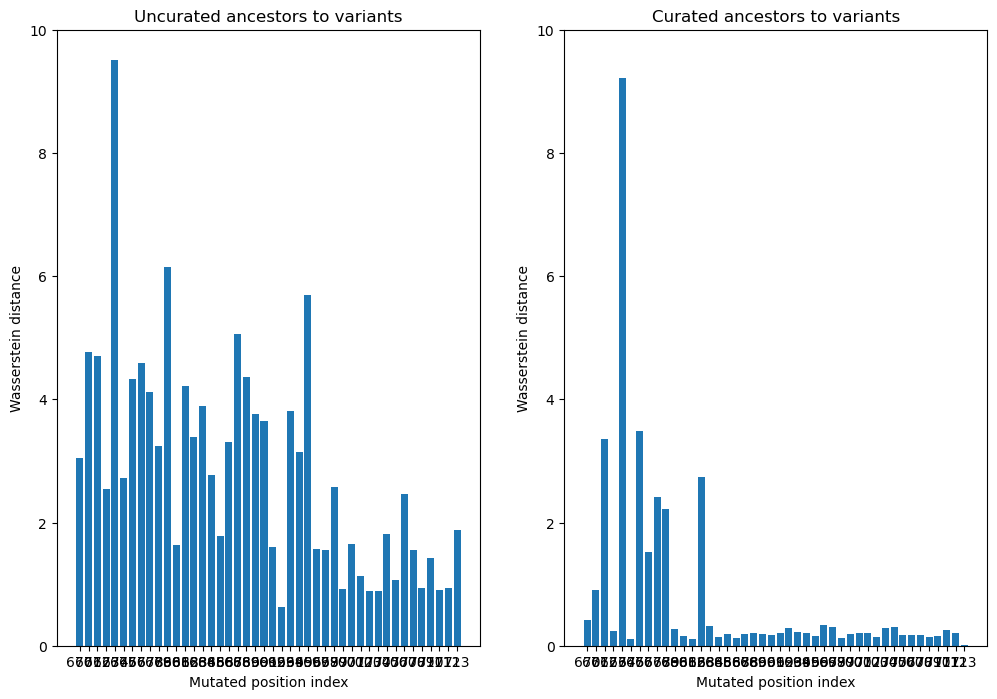

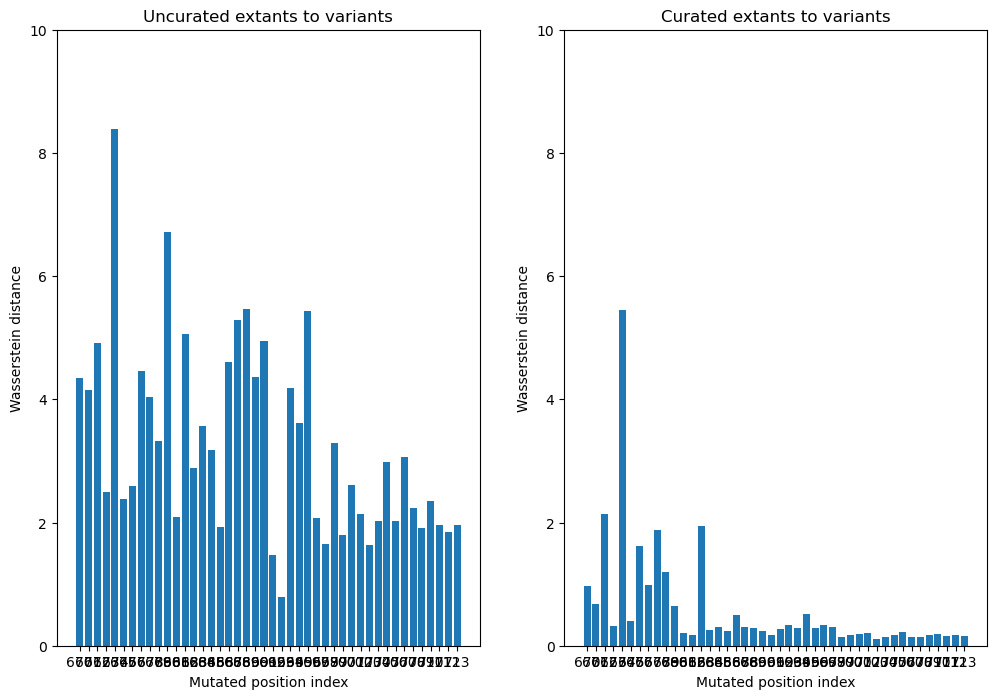

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
mutations = [x for x in range(670, 714)]
plot_wasserstein_dist(wd_a_to_v, mutations=mutations, title="Uncurated ancestors to variants", ax=ax1)

mutations = [x for x in range(670, 714)]
plot_wasserstein_dist(wd_curated_a_to_v, mutations=mutations, title="Curated ancestors to variants", ax=ax2)

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
mutations = [x for x in range(670, 714)]
plot_wasserstein_dist(wd_e_to_v, mutations=mutations, title="Uncurated extants to variants", ax=ax1)

mutations = [x for x in range(670, 714)]
plot_wasserstein_dist(wd_curated_e_to_v, mutations=mutations, title="Curated extants to variants", ax=ax2)

plt.show()



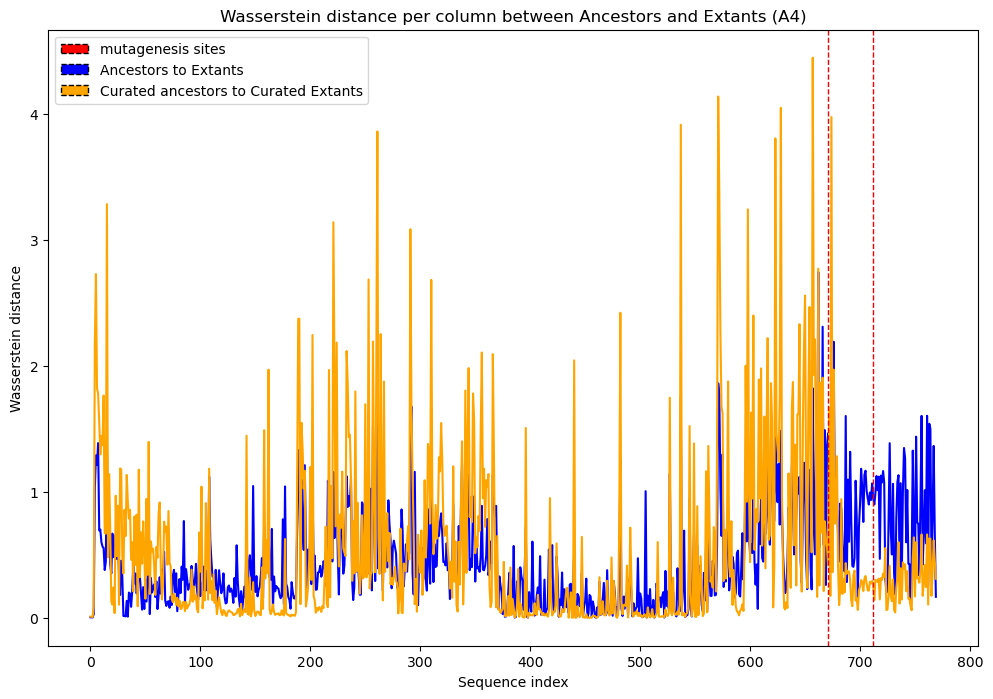

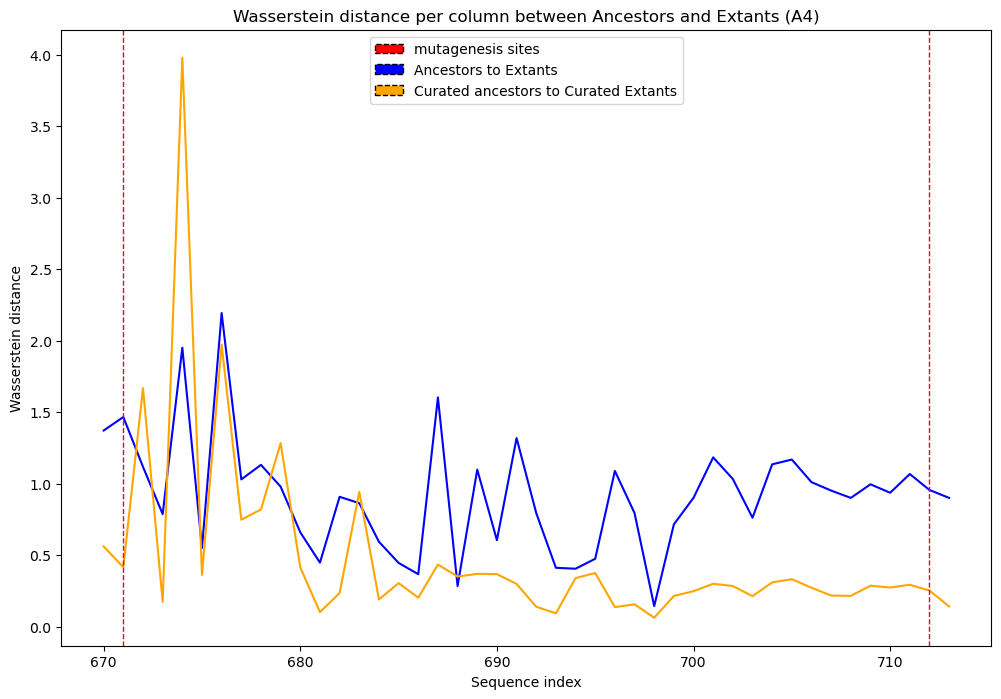

In [75]:
xticks = range(0, len(wd_a_to_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, wd_a_to_e, alpha=1, color='blue')
plt.plot(xticks, wd_curated_a_to_curated_e, alpha=1, color='orange')
mutations = [671, 712]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=1)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',linestyle='--', label='Ancestors to Extants '),
    Patch(facecolor='orange', edgecolor='black',linestyle='--', label='Curated ancestors to Curated Extants'),
]

plt.legend(handles=legend_elements,)
plt.ylabel("Wasserstein distance")
plt.xlabel("Sequence index")
plt.title("Wasserstein distance per column between Ancestors and Extants (A4)")
plt.show()


################### ONLY ACROSS MUTATIONS ##################

xticks = range(0, len(wd_a_to_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks[670:714], wd_a_to_e[670:714], alpha=1, color='blue')
plt.plot(xticks[670:714], wd_curated_a_to_curated_e[670:714], alpha=1, color='orange')
mutations = [671, 712]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=1)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',linestyle='--', label='Ancestors to Extants '),
    Patch(facecolor='orange', edgecolor='black',linestyle='--', label='Curated ancestors to Curated Extants'),
]

plt.legend(handles=legend_elements,)
plt.ylabel("Wasserstein distance")
plt.xlabel("Sequence index")
plt.title("Wasserstein distance per column between Ancestors and Extants (A4)")
plt.show()


# GCN4 

In [19]:
gcn4_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GCN4_YEAST_Staller_2018.csv")
gcn4_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,D103A,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.543932,1
1,D103A:F108N:K118D:S122Q:V135I:D139W,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.158042,0
2,D103A:S104T:T105I:P106T:M107L:F108T:E109S:N112...,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.391235,1
3,D103A:S122A:V130Q:T132M:S144N,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.243840,0
4,D103A:S122E:S136P:K140S:A141R,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.678492,1


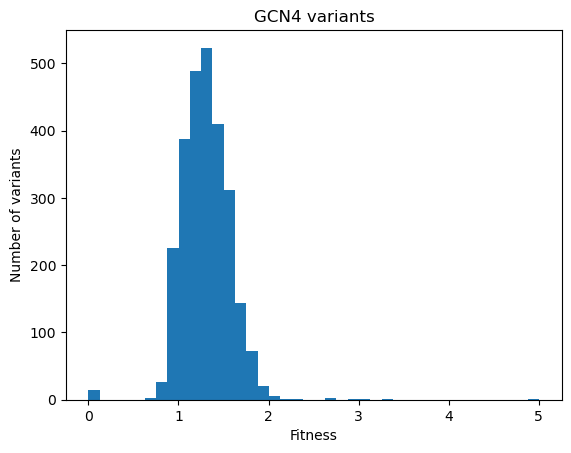

In [128]:
gcn4_variants["DMS_score"].describe()

plt.hist(gcn4_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("GCN4 variants")
plt.show()

### GCN4 - entropy 

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 283
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 9171
Sequence weight numpy array created with shape (num_seqs, columns):  (331, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (11623, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (283, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (9171, 281)


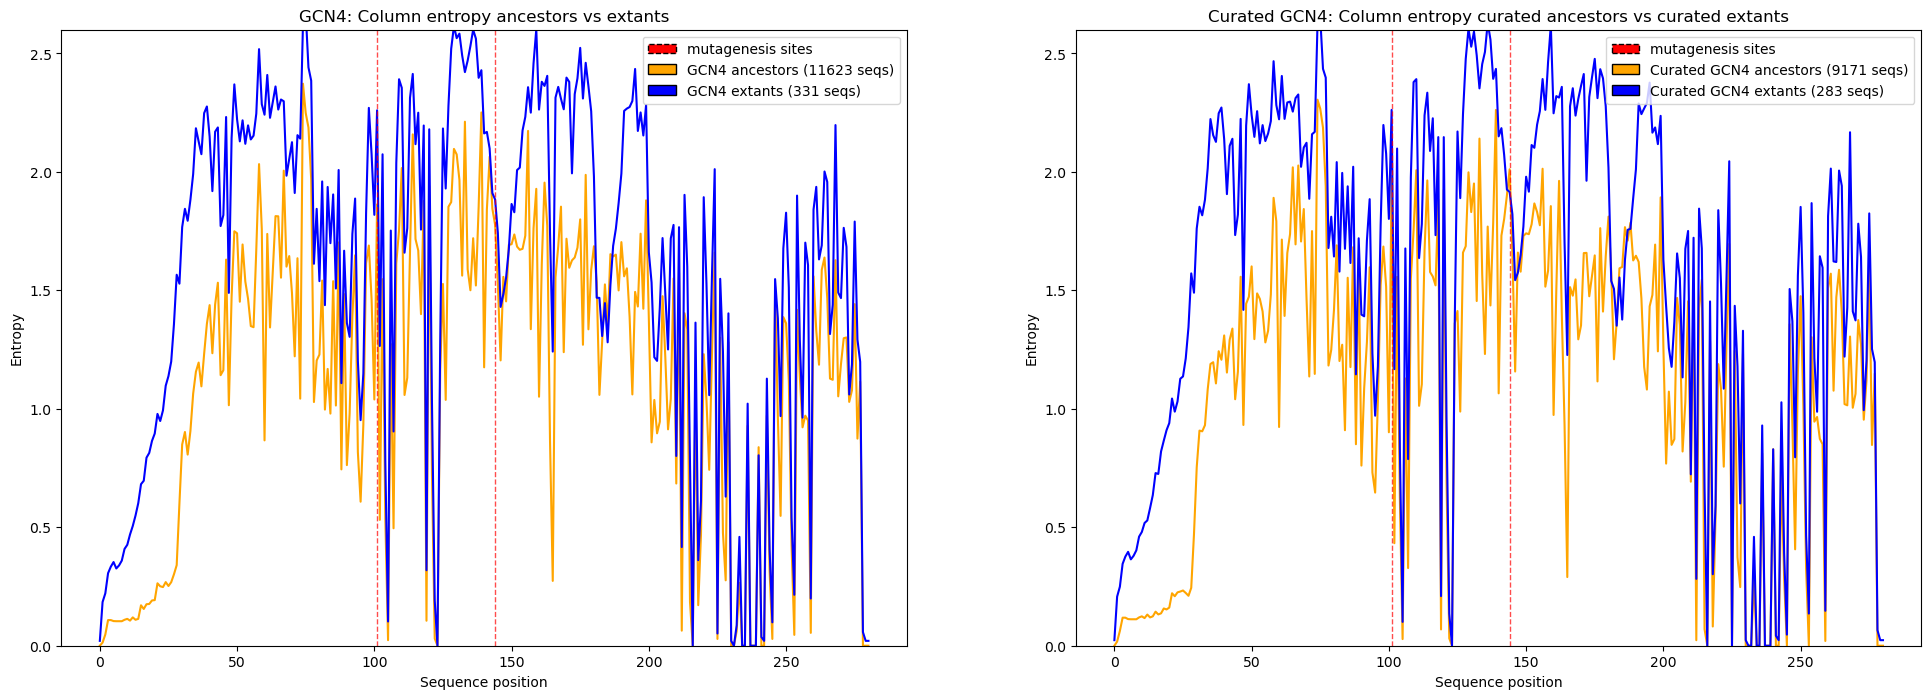

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

Sequence weight numpy array created with shape (num_seqs, columns):  (331, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (11623, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (283, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (9171, 281)


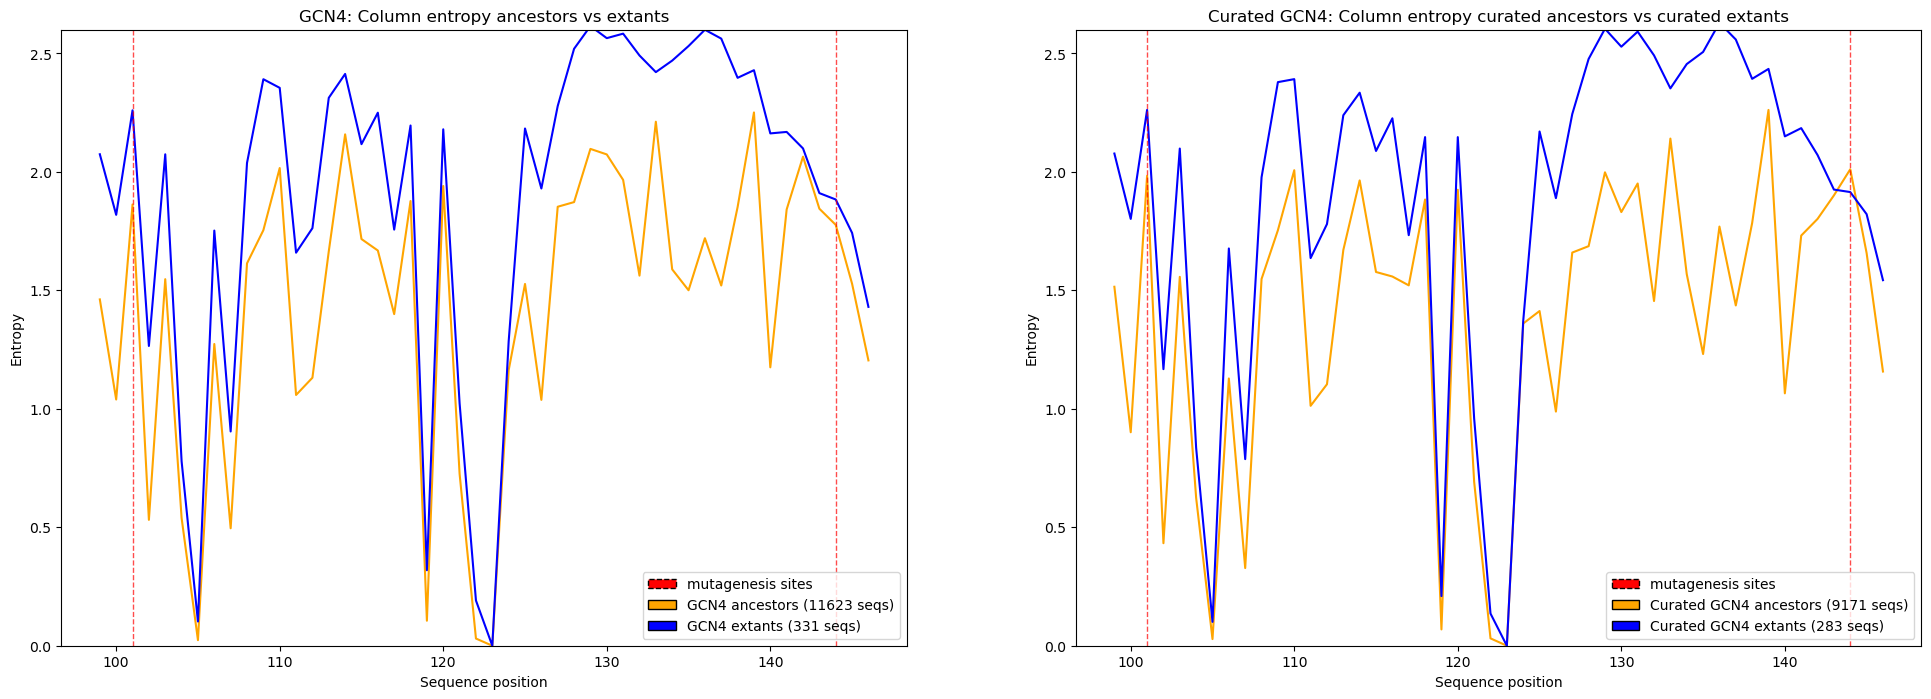

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [5]:
################ UNCURATED ##############

aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/"
gcn4_e = pd.read_pickle(aln_path + "gcn4_extants_no_dupes.pkl")
gcn4_a = pd.read_pickle(aln_path + "gcn4_ancestors_no_dupes.pkl")

################### CURATED ANCESTORS & EXTANTS ##################
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/"
curated_gcn4_e = st.read_aln_file(aln_path + "gcn4_0.3_sim_extants_no_dupes.aln")
curated_gcn4_a = st.read_aln_file(aln_path + "gcn4_0.3_sim_ancestors_no_dupes.aln")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

plot_entropy(ancestors=gcn4_a, extants=gcn4_e, anc_count=11623, 
             ext_count=331, mutations = [101, 144], protein="GCN4", 
             title="Column entropy ancestors vs extants", ax=ax1)

plot_entropy(ancestors=curated_gcn4_a, extants=curated_gcn4_e, anc_count=9171, 
             ext_count=283, mutations = [101, 144], protein="Curated GCN4", 
             title="Column entropy curated ancestors vs curated extants", ax=ax2)

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# do across a smaller range 
plot_entropy(ancestors=gcn4_a, extants=gcn4_e, anc_count=11623, 
             ext_count=331, mutations = [101, 144], protein="GCN4", 
             title="Column entropy ancestors vs extants", start=99, end=147, ax=ax1)


plot_entropy(ancestors=curated_gcn4_a, extants=curated_gcn4_e, anc_count=9171, 
             ext_count=283, mutations = [101, 144], protein="Curated GCN4", 
             title="Column entropy curated ancestors vs curated extants", start=99, end=147, ax=ax2)

plt.show()



##### GCN4 - Wasserstein distance

Sequence weight numpy array created with shape (num_seqs, columns):  (11623, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (331, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (11904, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (2638, 281)
Dist A-E: 1.174627319740789
Dist A-AE: 0.027319806576114106
Dist E-AE: 1.147387000625605
Dist A-V: 4.484926744625584
Dist E-V: 4.533220287500702
Dist AE-V: 4.486078513005525
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 9171
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_ancestors_0.3_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 9419
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim

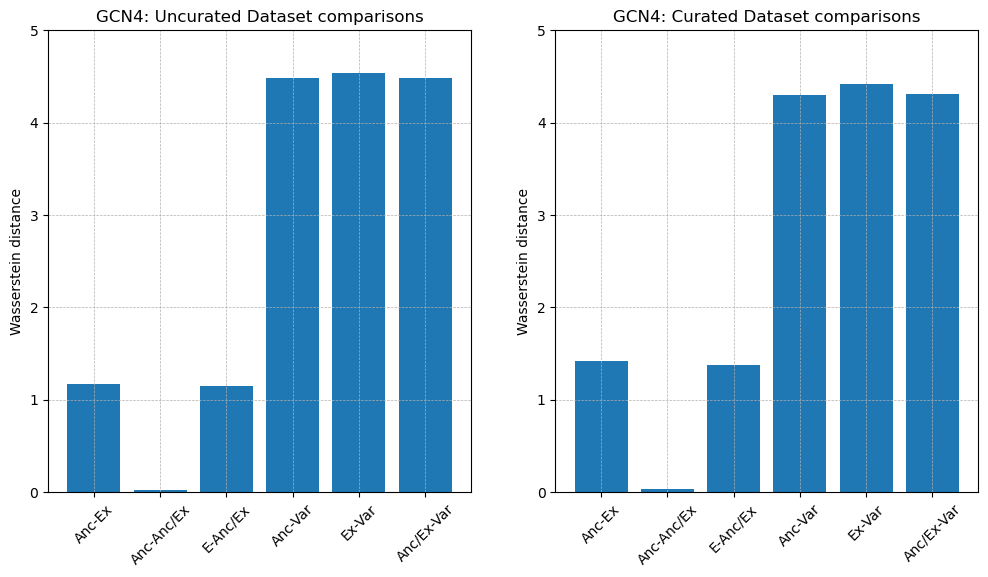

In [39]:


################ UNCURATED ##############
path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/"
wd_a_to_e, wd_a_to_ae, wd_e_to_ae, wd_a_to_v, wd_e_to_v, wd_ae_to_v = calc_column_wasserstein_distances(
    ancestors= path + "gcn4_ancestors_no_dupes.pkl",
    extants= path + "gcn4_extants_no_dupes.pkl",
    ancestors_extants= path + "gcn4_ancestors_extants_no_dupes.pkl",
    variants="/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GCN4_YEAST_Staller_2018.csv")

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")


################### CURATED ANCESTORS & EXTANTS ##################

path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/"
wd_curated_a_to_curated_e, wd_curated_a_to_curated_ae, wd_curated_e_to_curated_ae, wd_curated_a_to_v, wd_curated_e_to_v, wd_curated_ae_to_v = calc_column_wasserstein_distances(
    ancestors= path + "gcn4_0.3_sim_ancestors_no_dupes.aln",
    extants= path + "gcn4_0.3_sim_extants_no_dupes.aln",
    ancestors_extants= path + "gcn4_0.3_sim_ancestors_0.3_sim_extants_no_dupes.aln",
    variants="/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GCN4_YEAST_Staller_2018.csv")

print(f"Dist curated A-E: {np.mean(wd_curated_a_to_curated_e)}")
print(f"Dist curated A-AE: {np.mean(wd_curated_a_to_curated_ae)}")
print(f"Dist curated E-AE: {np.mean(wd_curated_e_to_curated_ae)}") 

print(f"Dist curated A-V: {np.mean(wd_curated_a_to_v)}")
print(f"Dist curated E-V: {np.mean(wd_curated_e_to_v)}")
print(f"Dist curated AE-V: {np.mean(wd_curated_ae_to_v)}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_e_to_v), np.mean(wd_ae_to_v)])
ax1.set_title("GCN4: Uncurated Dataset comparisons")
ax1.set_ylabel("Wasserstein distance")
ax1.set_xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], rotation=45)
ax1.set_ylim(0,5)
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)


ax2.bar(np.arange(6), [np.mean(wd_curated_a_to_curated_e), np.mean(wd_curated_a_to_curated_ae), np.mean(wd_curated_e_to_curated_ae), np.mean(wd_curated_a_to_v), np.mean(wd_curated_e_to_v), np.mean(wd_curated_ae_to_v)])
ax2.set_title("GCN4: Curated Dataset comparisons")
ax2.set_ylabel("Wasserstein distance")
ax2.set_xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], rotation=45)
ax2.set_ylim(0,5)
ax2.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)


plt.show()


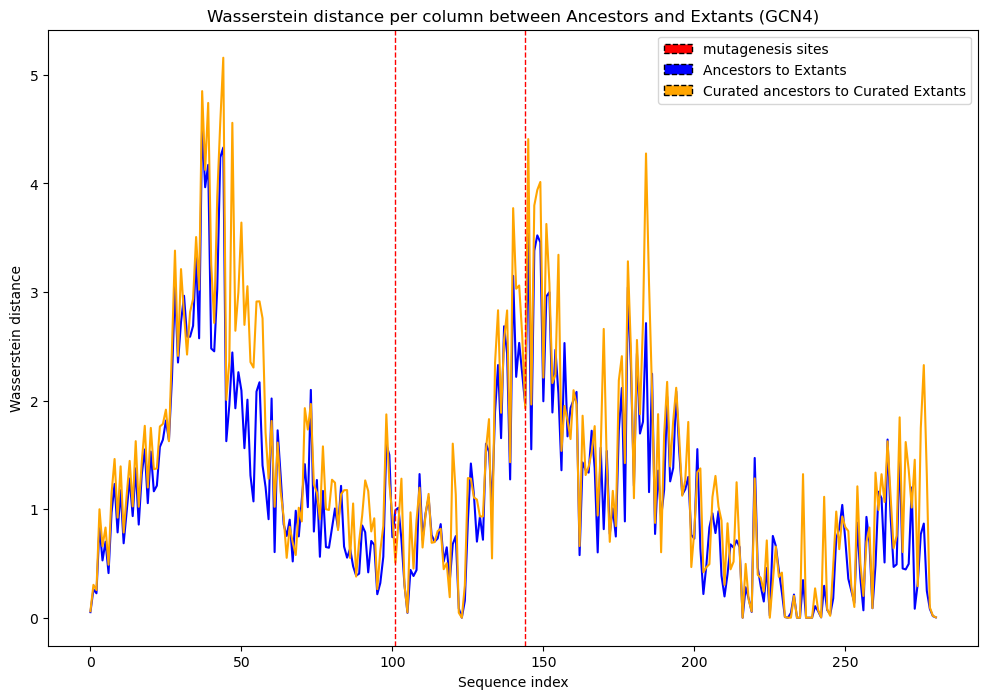

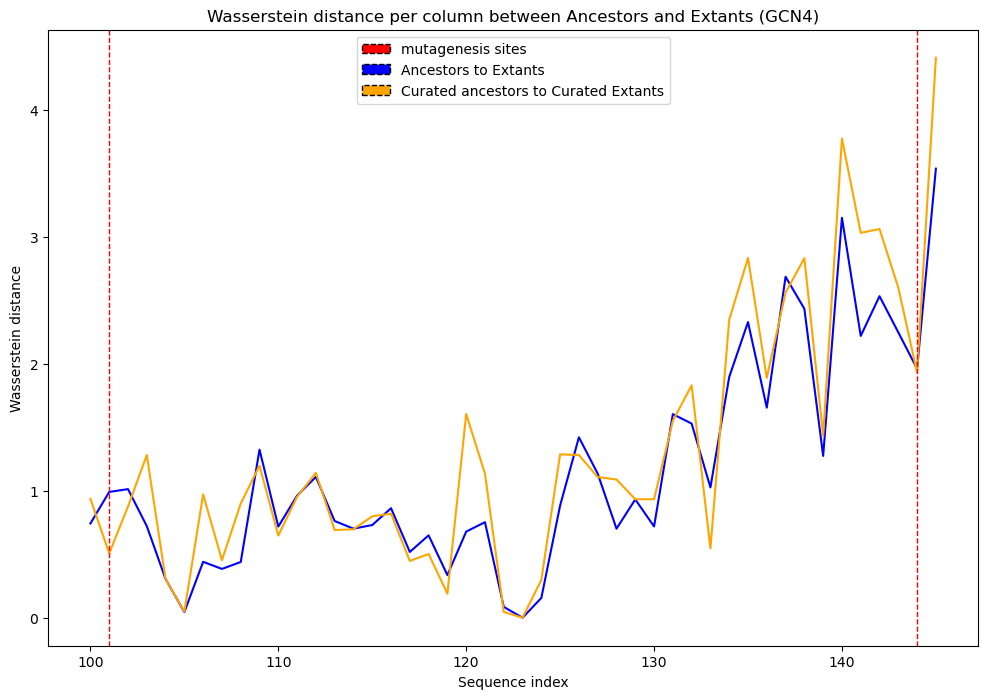

In [180]:
################ UNCURATED ##############
xticks = range(0, len(wd_a_to_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, wd_a_to_e, alpha=1, color='blue', label="Ancestors-Extants")
plt.plot(xticks, wd_curated_a_to_curated_e, alpha=1, color='orange', label="Curated Ancestors- Curated Extants")
mutations = [101, 144]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=1)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',linestyle='--', label='Ancestors to Extants '),
    Patch(facecolor='orange', edgecolor='black',linestyle='--', label='Curated ancestors to Curated Extants'),
]

plt.legend(handles=legend_elements,)
plt.ylabel("Wasserstein distance")
plt.xlabel("Sequence index")
plt.title("Wasserstein distance per column between Ancestors and Extants (GCN4)")
plt.show()


################### CURATED ANCESTORS & EXTANTS ##################
xticks = range(0, len(wd_curated_a_to_curated_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks[100:146], wd_a_to_e[100:146], alpha=1, color='blue', label="Ancestors-Extants")
plt.plot(xticks[100:146], wd_curated_a_to_curated_e[100:146], alpha=1, color='orange', label="Curated ancestors-Extants")


mutations = [101, 144]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=1)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',linestyle='--', label='Ancestors to Extants '),
    Patch(facecolor='orange', edgecolor='black',linestyle='--', label='Curated ancestors to Curated Extants'),
]

plt.legend(handles=legend_elements,)
plt.ylabel("Wasserstein distance")
plt.xlabel("Sequence index")

plt.title("Wasserstein distance per column between Ancestors and Extants (GCN4)")
plt.show()

#### GCN4 - curated sequence weights distributions 

In [7]:

################ UNCURATED ##############

aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/"
gcn4_e = pd.read_pickle(aln_path + "gcn4_extants_no_dupes.pkl")
gcn4_a = pd.read_pickle(aln_path + "gcn4_ancestors_no_dupes.pkl")
gcn4_ae = pd.read_pickle(aln_path + "gcn4_ancestors_extants_no_dupes.pkl")

################### CURATED ANCESTORS & EXTANTS ##################
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/"
curated_gcn4_e = st.read_aln_file(aln_path + "gcn4_0.3_sim_extants_no_dupes.aln")
curated_gcn4_a = st.read_aln_file(aln_path + "gcn4_0.3_sim_ancestors_no_dupes.aln")
curated_gcn4_ae = st.read_aln_file(aln_path + "gcn4_0.3_sim_ancestors_0.3_sim_extants_no_dupes.aln")

datasets = [gcn4_e, gcn4_a, gcn4_ae, curated_gcn4_e, curated_gcn4_a, curated_gcn4_ae]

for data in datasets:
    numpy_aln, _, _ = st.convert_msa_numpy_array(data)
    data["seq_sim"] = st.reweight_by_seq_similarity(numpy_aln, 0.2)
    data["col_sim"] = st.position_based_seq_weighting(numpy_aln, 4)

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 283
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 9171
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_ancestors_0.3_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 9419
Sequence weight numpy array created with shape (num_seqs, columns):  (331, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (11623, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (11904, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (283, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (9171, 28

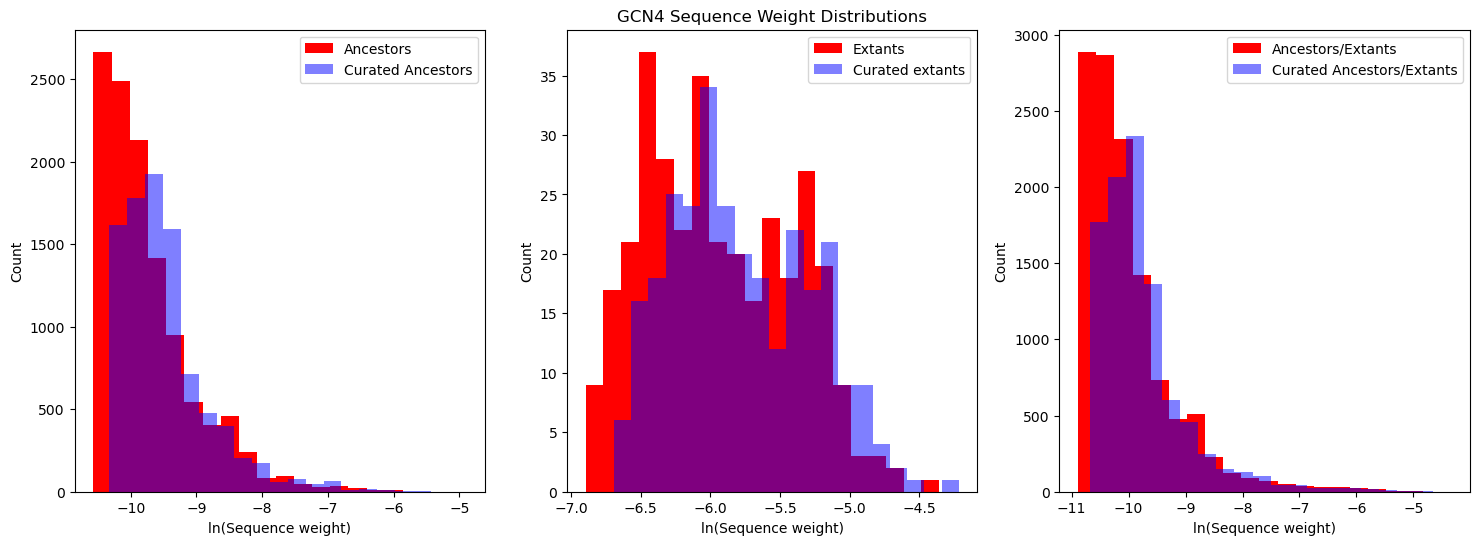

In [9]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.hist(np.log(gcn4_a["col_sim"]), color="red", alpha=1, bins=20, label="Ancestors")
ax1.hist(np.log(curated_gcn4_a["col_sim"]), color="blue", alpha=0.5, bins=20, label="Curated Ancestors")

ax1.set_ylabel("Count")
ax1.set_xlabel("ln(Sequence weight)")

ax1.legend()


ax2.hist(np.log(gcn4_e["col_sim"]), color="red", alpha=1, bins=20, label="Extants")
ax2.hist(np.log(curated_gcn4_e["col_sim"]), color="blue", alpha=0.5, bins=20, label="Curated extants")

ax2.set_ylabel("Count")
ax2.set_xlabel("ln(Sequence weight)")

ax2.set_title("GCN4 Sequence Weight Distributions")
ax2.legend()



ax3.hist(np.log(gcn4_ae["col_sim"]), color="red", alpha=1, bins=20, label="Ancestors/Extants")
ax3.hist(np.log(curated_gcn4_ae["col_sim"]), color="blue", alpha=0.5, bins=20, label="Curated Ancestors/Extants")
ax3.set_ylabel("Count")
ax3.set_xlabel("ln(Sequence weight)")

ax3.legend()

plt.show()



# MAFG 

In [11]:
mafg_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/MAFG_MOUSE_Tsuboyama_2023_1K1V.csv")
mafg_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,D3A,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQRRRTLKNRGY,-1.274690,0
1,D3A:R32A,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQARRTLKNRGY,-1.637233,0
2,D3A:R32C,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQCRRTLKNRGY,-1.081258,0
3,D3A:R32D,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQDRRTLKNRGY,-1.938164,0
4,D3A:R32E,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQERRTLKNRGY,-1.893906,0


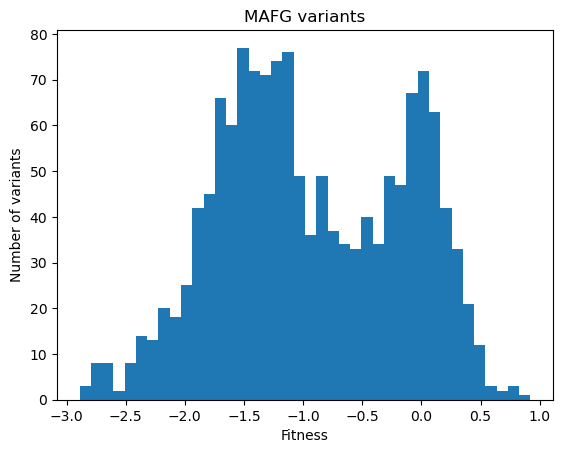

In [24]:
mafg_variants["DMS_score"].describe()

plt.hist(mafg_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("MAFG variants")
plt.show()

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/mafg_extants_no_dupes.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 962
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/mafg_ancestors_no_dupes.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 3682
Sequence weight numpy array created with shape (num_seqs, columns):  (962, 41)
Sequence weight numpy array created with shape (num_seqs, columns):  (3682, 41)


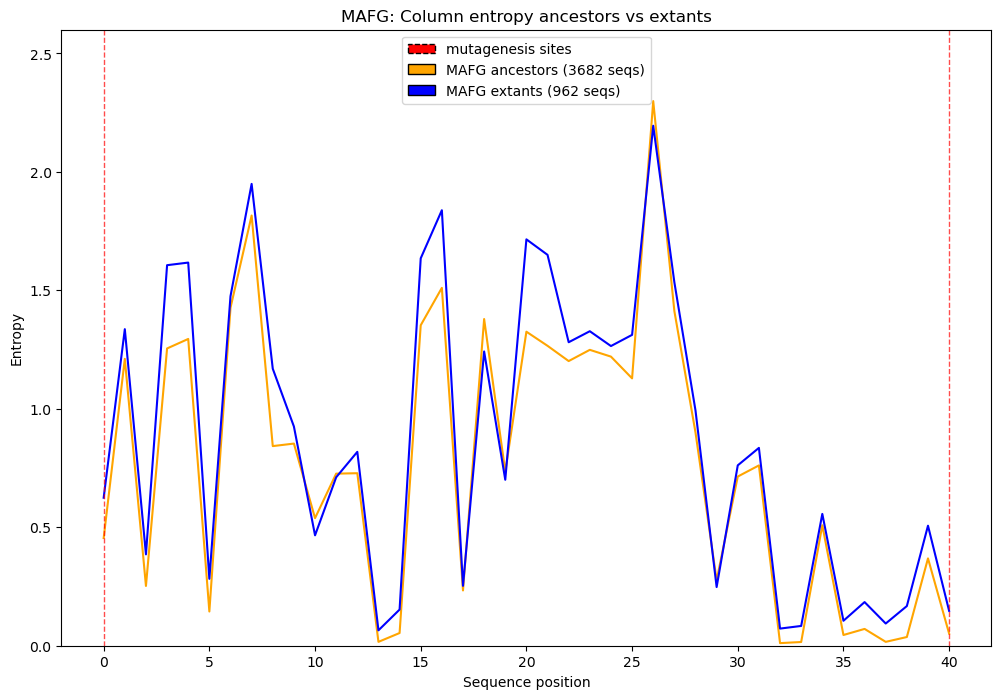

<Figure size 1200x800 with 0 Axes>

In [14]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/"
gcn4_e = st.read_aln_file(aln_path + "mafg_extants_no_dupes.fasta")
gcn4_a = st.read_aln_file(aln_path + "mafg_ancestors_no_dupes.fasta")

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

plot_entropy(ancestors=gcn4_a, extants=gcn4_e, anc_count=3682, 
             ext_count=962, mutations = [0, 40], protein="MAFG", 
             title="Column entropy ancestors vs extants", ax=ax1)


plt.show()

### MAFG - Wasserstein Distance

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/mafg_ancestors_no_dupes.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 3682
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/mafg_ancestors_extants_no_dupes.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 3965
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/mafg_extants_no_dupes.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 962
Sequence weight numpy array created with shape (num_seqs, columns):  (3682, 41)
Sequence weight numpy array created with shape (num_seqs, columns):  (962, 41)
Sequence weight numpy array created with shape (num_seqs, columns):  (3965, 41)
Sequence weight numpy array created with shape (num_seqs, columns):  (1429, 41)
Dist A-E: 0.4310420149240516
Dist A-AE: 0.03613274449548296
Dist E-AE: 0.39826530926091114
Dist A-V: 1.607947931858

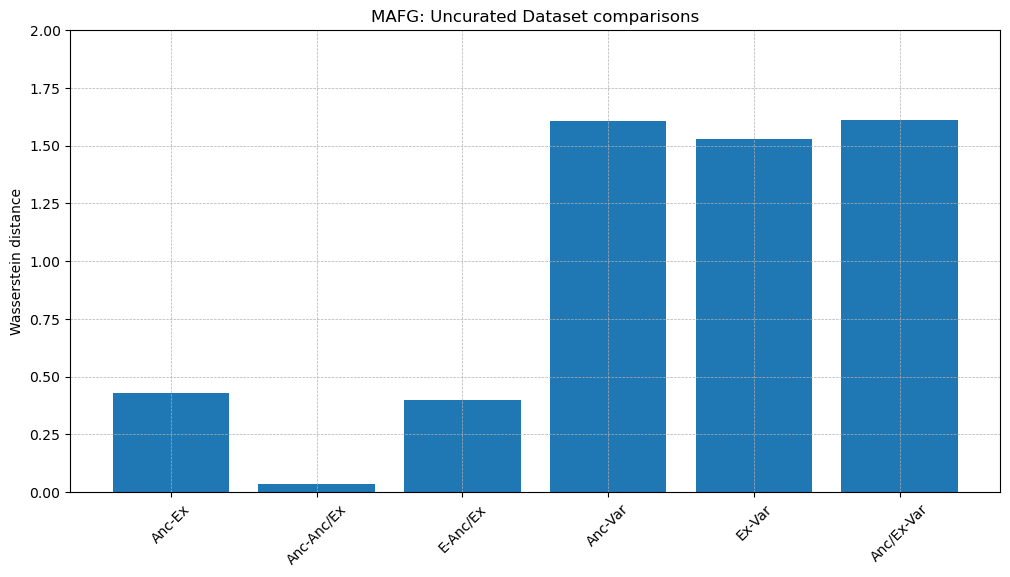

In [40]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/"

wd_a_to_e, wd_a_to_ae, wd_e_to_ae, wd_a_to_v, wd_e_to_v, wd_ae_to_v = calc_column_wasserstein_distances(
    ancestors= path + "mafg_ancestors_no_dupes.fasta",
    extants= path + "mafg_extants_no_dupes.fasta",
    ancestors_extants= path + "mafg_ancestors_extants_no_dupes.fasta",
    variants="/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/MAFG_MOUSE_Tsuboyama_2023_1K1V.csv")

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 6))

ax1.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_e_to_v), np.mean(wd_ae_to_v)])
ax1.set_title("MAFG: Uncurated Dataset comparisons")
ax1.set_ylabel("Wasserstein distance")
ax1.set_xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], rotation=45)
ax1.set_ylim(0,2)
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.show()



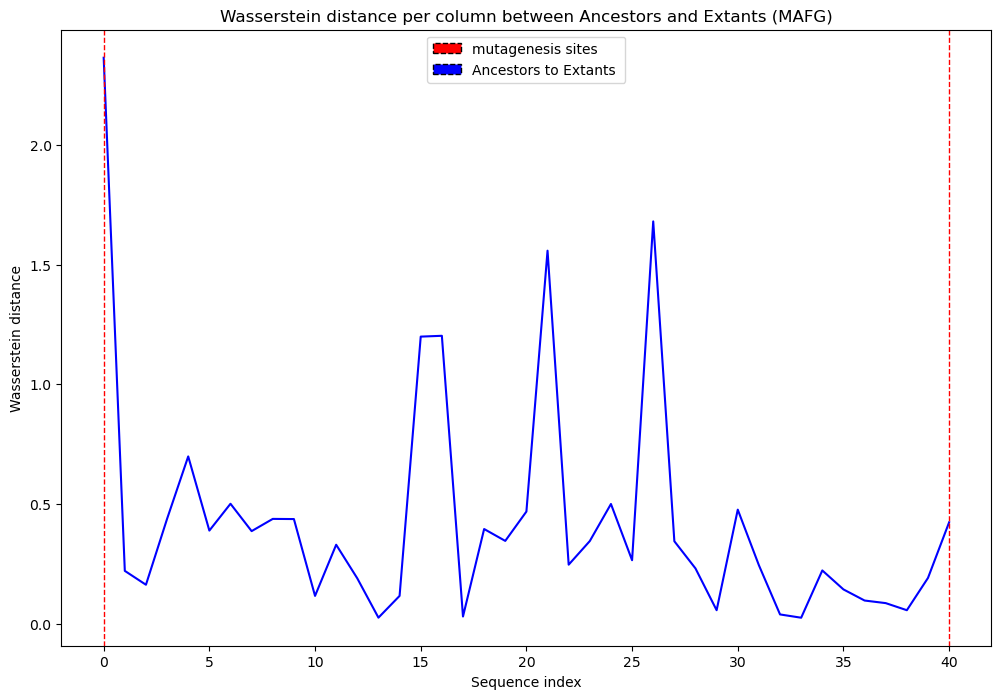

In [41]:
################ UNCURATED ##############
xticks = range(0, len(wd_a_to_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, wd_a_to_e, alpha=1, color='blue', label="Ancestors-Extants")
mutations = [0, 40]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=1)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',linestyle='--', label='Ancestors to Extants '),
]

plt.legend(handles=legend_elements,)
plt.ylabel("Wasserstein distance")
plt.xlabel("Sequence index")
plt.title("Wasserstein distance per column between Ancestors and Extants (MAFG)")
plt.show()